In [155]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from scipy import stats
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install xlsxwriter
pd.options.mode.chained_assignment = None  # default='warn'
import statsmodels.api as sm
from statsmodels.formula.api import ols
## https://www.kaggle.com/code/alexmaszanski/two-way-anova-with-python/notebook
from scipy.stats import linregress
import glob
import researchpy as rp
import re

**There are four assumptions that must be met before using two-way ANOVA:**

- Normality: Observations from the sample population are normally distributed.
- Sample Size: The number of observations must be the same for each group.
- Equal Variances: The variances for each group are equal.
- Independence: Observations in each group are independent.

In [30]:
currdir= os.getcwd()
parent = os.path.dirname(currdir)
gparent=os.path.dirname(parent)
lines_to_skip = 10 # adjust this as necessary

# count the number of header lines
header_lines = 3 # adjust this as necessary

plate_type = 'DIV19'
# read the csv file into a pandas DataFrame, skipping the metadata at the top
# df = pd.read_csv(filename, skiprows=lines_to_skip, header=[i for i in range(header_lines)])
### read all data

firstTableHeading = "Mean Firing Rate (Hz)"
## conditions taken:
basal_folder = f"data/Div19_basal/"
bicu2uM_folder = f"data/Div19_2uMbicucilin/"
bicu6uM_folder = f"data/Div19_6uMbicucilin/"
bicu26uM_folder = f"data/Div19_26uMbicucilin/"

# basal_df= pd.read_csv(f"data/Div19_2way/Div19 H11 5th batch of gRNAs plate2 basal(000)(000)_CompiledData(1).csv",
#                     skiprows = lines_to_skip)

# bicucilin_df = pd.read_csv(f"data/Div19_2way/Div19 H11 5th batch of gRNAs plate2 bicu 6 microM(000)(000)_CompiledData.csv",
#                          skiprows = lines_to_skip)

# basal_df = basal_df.drop(columns=['Unnamed: 9']) # , 'Unnamed: 0'
# bicucilin_df = bicucilin_df.drop(columns=['Unnamed: 9']) # , 'Unnamed: 0'
# basal_df

In [31]:
def read_csvs_to_dict(folder):
    files = glob.glob(os.path.join(folder, "*.csv"))
    data_dict = {}
    for file in files:
        # Extracting the plate number from the filename
        plate_num = re.search(r'plate\s?(\d+)', file, re.IGNORECASE)
        if plate_num:
            plate_key = f"plate_{plate_num.group(1)}"
            df = pd.read_csv(file, skiprows = lines_to_skip)
            df = df.drop(columns=['Unnamed: 9'])
            data_dict[plate_key] = df
    return data_dict
basal_files_dict = read_csvs_to_dict(basal_folder)
bicu2uM_files_dict = read_csvs_to_dict(bicu2uM_folder)
bicu6uM_files_dict = read_csvs_to_dict(bicu6uM_folder)
bicu26uM_files_dict = read_csvs_to_dict(bicu26uM_folder)

basal_files_dict.keys()


dict_keys(['plate_3', 'plate_2', 'plate_1'])

In [56]:
def concat_plates(dfs_dict, firstHeading):
    experiment = {}
    testparams_concat = {}
    for plate, df in dfs_dict.items():
        maxrows = df.shape[0]
        vals_between_tables = 16
        titles = [heading_ind for heading_ind in range(14, maxrows+16, 16)]
        titles.insert(0,0)
        # # Empty dictionary to store dataframes
        # Loop through start indices
        for ind in range(len(titles) -1):
            if ind == 0:
                ## Handle mean firing rate
                key = firstHeading
                table = df.iloc[titles[ind] : titles[ind +1], :]
                # table = rename_row_names(table)
            elif ind != 0:
                table = df.iloc[titles[ind] : titles[ind +1], :]
                key = table.iloc[0][0] # just get name
                table = df.iloc[titles[ind] +2: titles[ind +1], :]

            table.set_index('Unnamed: 0', inplace=True)
            if key not in experiment:
                experiment[key] = []
            experiment[key].append(table)
    
    for testparam, df_list in experiment.items():
        concated_table = pd.concat(df_list, ignore_index=False)
        testparams_concat[testparam] = concated_table
        
    return testparams_concat

basal_dict_wmeanSEM= concat_plates(basal_files_dict, firstTableHeading)
bicu2uM_dict_wmeanSEM = concat_plates(bicu2uM_files_dict, firstTableHeading)
bicu6uM_dict_wmeanSEM = concat_plates(bicu6uM_files_dict, firstTableHeading)
bicu26uM_dict_wmeanSEM = concat_plates(bicu26uM_files_dict, firstTableHeading)


In [141]:
def remove_mean_SEM(dictionary, chemical_type):
    for key, value in dictionary.items():
        to_drop = [index for index in ['B Mean', 'B SEM'] if index in value.index]
        if to_drop:
            dictionary[key] = value.drop(index=to_drop)
        dictionary[key]['Chemical_Type']=chemical_type
    return dictionary

basal_dictmessy = remove_mean_SEM(basal_dict_wmeanSEM, chemical_type="basal")
bicu2uM_dictmessy = remove_mean_SEM(bicu2uM_dict_wmeanSEM,chemical_type="bicucilin2uM")
bicu6uM_dictmessy = remove_mean_SEM(bicu6uM_dict_wmeanSEM, chemical_type="bicucilin6uM")
bicu26uM_dictmessy = remove_mean_SEM(bicu26uM_dict_wmeanSEM, chemical_type="bicucilin26uM")
# print(basal_dict['Number of Covered Electrodes'].columns)
basal_dictmessy['Mean Firing Rate (Hz)']


,GPR37L 1,GPR37L 2,LGI2 A12,SLITRK5,THSD7 1,THSD7 2,unt1,unt2,Chemical_Type
Unnamed: 0,,,,,,,,,
B Replicates,5.499162,6.382907,2.914956,6.604943,1.848974,4.715961,7.738165,8.244240,basal
NaN,1.969837,2.550272,3.842061,6.861332,0.395894,0.851906,4.451822,3.873900,basal
NaN,4.607457,4.936531,1.399036,3.757646,1.762463,2.645371,3.083997,4.488270,basal
NaN,4.511311,2.952870,0.775031,5.469418,0.766234,0.544826,3.708840,3.776288,basal
NaN,3.115207,5.353163,0.837662,4.427105,1.601801,2.540218,4.283201,1.315459,basal
NaN,1.804357,3.315040,1.546083,2.927943,3.330750,2.988898,5.991621,0.952241,basal
NaN,0.932342,7.577922,0.630708,5.498324,1.004189,4.395057,3.929828,1.611227,basal
NaN,1.185589,3.292836,0.627357,2.138877,7.265396,3.890658,4.688731,6.458525,basal
NaN,0.686845,3.314830,1.449937,5.293465,0.934227,2.104315,5.498534,0.459992,basal


In [142]:
def rename_row_names(experiment_df):
    # 'Unnamed: 0' is a column
    experiment_df = experiment_df.reset_index()
    experiment_df = experiment_df.drop(columns="Unnamed: 0", errors="ignore")
    experiment_df.index = ["Replicate{}".format(i+1) for i in range(len(experiment_df))]
    return experiment_df

basal_dict = {key: rename_row_names(df) for key, df in basal_dictmessy.items()}
bicu2uM_dict = {key: rename_row_names(df) for key, df in bicu2uM_dictmessy.items()}
bicu6uM_dict = {key: rename_row_names(df) for key, df in bicu6uM_dictmessy.items()}
bicu26uM_dict = {key: rename_row_names(df) for key, df in bicu26uM_dictmessy.items()}

bicu26uM_dict['Area Under Normalized Cross-Correlation']

,GPR37L 1,GPR37L 2,LGI2 A12,SLITRK5,THSD7 1,THSD7 2,unt1,unt2,Chemical_Type
Replicate1,0.533677,0.809507,0.586545,0.779376,0.726451,0.762818,0.645288,0.749028,bicucilin26uM
Replicate2,0.634711,0.665844,0.527346,0.972523,0.744121,0.758033,0.688617,0.801062,bicucilin26uM
Replicate3,0.741584,0.831252,0.808536,0.406702,0.649350,0.584606,0.670271,0.861351,bicucilin26uM
Replicate4,0.693815,0.577041,0.694507,0.722339,0.642456,0.566732,0.082474,0.713040,bicucilin26uM
Replicate5,0.743830,0.471847,0.726682,0.801686,0.827754,0.813127,0.690153,0.624583,bicucilin26uM
Replicate6,0.785165,0.823597,0.709180,0.604687,0.767200,0.796547,0.760966,0.750292,bicucilin26uM
Replicate7,0.578987,0.555004,0.773613,0.676289,0.818223,0.780559,0.755560,0.675934,bicucilin26uM
Replicate8,0.568383,0.584358,0.782908,0.775004,0.651270,0.865591,0.866887,0.781285,bicucilin26uM
Replicate9,0.702548,0.595860,0.901564,0.872534,0.604923,0.820587,0.796730,0.817439,bicucilin26uM
Replicate10,0.575255,0.557448,0.692400,0.939721,0.485701,0.751910,0.662139,0.641429,bicucilin26uM


In [143]:
all_dicts = dict(zip(["basal", "bicucilin2uM", "bicucilin6uM", "bicucilin26uM"],[basal_dict, bicu2uM_dict, bicu6uM_dict, bicu26uM_dict]))
all_dicts['basal']['Mean Firing Rate (Hz)']

,GPR37L 1,GPR37L 2,LGI2 A12,SLITRK5,THSD7 1,THSD7 2,unt1,unt2,Chemical_Type
Replicate1,5.499162,6.382907,2.914956,6.604943,1.848974,4.715961,7.738165,8.244240,basal
Replicate2,1.969837,2.550272,3.842061,6.861332,0.395894,0.851906,4.451822,3.873900,basal
Replicate3,4.607457,4.936531,1.399036,3.757646,1.762463,2.645371,3.083997,4.488270,basal
Replicate4,4.511311,2.952870,0.775031,5.469418,0.766234,0.544826,3.708840,3.776288,basal
Replicate5,3.115207,5.353163,0.837662,4.427105,1.601801,2.540218,4.283201,1.315459,basal
Replicate6,1.804357,3.315040,1.546083,2.927943,3.330750,2.988898,5.991621,0.952241,basal
Replicate7,0.932342,7.577922,0.630708,5.498324,1.004189,4.395057,3.929828,1.611227,basal
Replicate8,1.185589,3.292836,0.627357,2.138877,7.265396,3.890658,4.688731,6.458525,basal
Replicate9,0.686845,3.314830,1.449937,5.293465,0.934227,2.104315,5.498534,0.459992,basal
Replicate10,1.804776,2.031420,2.782153,6.433389,1.175115,1.072476,6.199623,3.814621,basal


In [144]:
def combine_chem_types(dict_of_alldicts):
    all_concat = {key: None for key in dict_of_alldicts['basal']}
    for type in dict_of_alldicts.keys():
        for test_parameter, df in dict_of_alldicts[type].items():
            all_concat[test_parameter]=pd.concat([all_concat[test_parameter], df], ignore_index=False)
    for testparam, df in all_concat.items():
        df.columns = df.columns.str.replace(' ', '_')
        for gene in df.columns:
            if gene != "Chemical_Type":
                df[gene]= df[gene].astype(float)
    return all_concat

TestParams_dict = combine_chem_types(all_dicts)
TestParams_dict['Network Burst Duration - Avg (sec)']

,GPR37L_1,GPR37L_2,LGI2_A12,SLITRK5,THSD7_1,THSD7_2,unt1,unt2,Chemical_Type
Replicate1,0.457755,0.449832,0.482957,0.452654,0.688599,0.413593,0.540432,0.510290,basal
Replicate2,0.837165,0.962000,0.225496,0.575814,0.371180,0.423360,0.602169,0.248789,basal
Replicate3,0.276134,0.629318,0.359040,0.516895,0.451300,0.239169,0.564575,0.585955,basal
Replicate4,0.215483,0.233952,0.527709,0.489302,0.463451,0.352709,0.595807,0.736915,basal
Replicate5,0.271620,0.478750,0.635695,0.706229,0.648710,0.228131,0.437105,0.391851,basal
...,...,...,...,...,...,...,...,...,...
Replicate32,0.633542,0.994762,0.505863,0.918491,0.633702,0.958327,0.398029,0.779906,bicucilin26uM
Replicate33,0.374026,0.430723,0.430768,0.425820,0.972284,0.778923,0.418950,0.669223,bicucilin26uM
Replicate34,0.526020,0.717378,0.381392,0.601596,0.501800,0.568092,0.520970,0.792578,bicucilin26uM
Replicate35,0.696169,0.798667,1.071426,0.399331,0.715442,0.735235,0.415511,0.533906,bicucilin26uM


In [145]:
def ensure_dirs_exists(path):
    directory = os.path.dirname(path)  # Get the directory part of the file path
    if not os.path.exists(directory):
        os.makedirs(directory)
    return

In [255]:
def addlabels(x, y, ax,slope=None, bar_width=0.35):
    for i in range(len(x)):
        # Place label slightly above the bar
        vertical_offset = y[i] #- max(y) * 0.4  # Adjusted as per your code
        ax.text(x[i], vertical_offset, round(y[i], 2), ha='center', fontweight='bold', fontsize=7,
                backgroundcolor='gray', alpha=0.7,  # Added alpha for transparency
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle="square,pad=0", lw=0))  # Bounding box
        ax.text(x[i], 0, round(x[i], 2))
        if slope:
                slope_position_x = x[i] + 0.1 
                slope_position_y = y[i] /2
                ax.text(slope_position_x, slope_position_y, f"Slope: {slope[i]:.2f}", ha='center', va='center', fontweight='bold', 
                        backgroundcolor='gray', alpha=0.9, color='green',
                        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle="round,pad=0.3", lw=0))

In [275]:
def calculate_ANOVA(testparameter, df, control_var="unt1"):
    order = list(df['Chemical_Type'].unique())
#     print("order", order)
    cols=2
    rows=int(np.ceil((len(df.columns)-3)/cols)) # 3 cols not mutation genes
    bar_width=0.20
    fig, axs = plt.subplots(rows, cols, figsize=(12,6*rows))
    fig.suptitle(testparameter, fontsize=20, y=1.03)
    for ri in range(rows):
        for ci in range(cols):
            ax = axs[ri, ci]
            column_index = ri * cols + ci
            print(column_index)
            mut_gene = rp.summary_cont(df.iloc[:, column_index].groupby(df['Chemical_Type']))
            control = rp.summary_cont(df[control_var].groupby(df['Chemical_Type']))
            categories=mut_gene.index
            r1 = range(len(mut_gene['Mean']))
            r2 = [x + bar_width for x in r1]
            ax.bar(r1, control['Mean'], color='blue', yerr=control['SD'],
                   capsize=7, width=bar_width, edgecolor='grey', ecolor='black', label=f'{control_var}')
            ax.bar(r2, mut_gene['Mean'], color='red', yerr=mut_gene['SD'],
                   capsize=7, width=bar_width, edgecolor='grey', ecolor='black', label=df.columns[ri+ci])
            slopes = [(mut_gene['Mean'][num] - control['Mean'][num])/(r2[num] - r1[num]) for num in range(len(control['Mean']))]
            addlabels(r1, control['Mean'], ax, slope=slopes)
            addlabels(r2, mut_gene['Mean'], ax)
            ax.set_xlabel('Perturbation', fontweight='bold')
            ax.set_xticks([r + bar_width/2 for r in range(len(mut_gene['Mean']))])
            ax.set_xticklabels(categories)
            ax.set_ylabel('Mean')
            ax.set_title(df.columns[column_index])
            ax.legend(loc='lower right')
    plt.tight_layout()
    save_figfile = f"ANOVA_plots/{plate_type}_ANOVAtest_{control_var}/{testparameter}"
    ensure_dirs_exists(save_figfile)
    plt.savefig(save_figfile)
    return


0




1




2




3




4




5




0




1




2




3




4




5




0




1




2




3




4




5




0




1




2




3




4




5




0




1




2




3




4




5




0




1




2




3




4




5




0




1




2




3




4




5




0




1




2




3




4




5




0




1




2




3




4




5




0




1




2




3




4




5




0




1




2




3




4




5




0




1




2




3




4




5




0




1




2




3




4




5




0




1




2




3




4




5




0




1




2




3




4




5




0




1




2




3




4




5




0




1




2




3




4




5






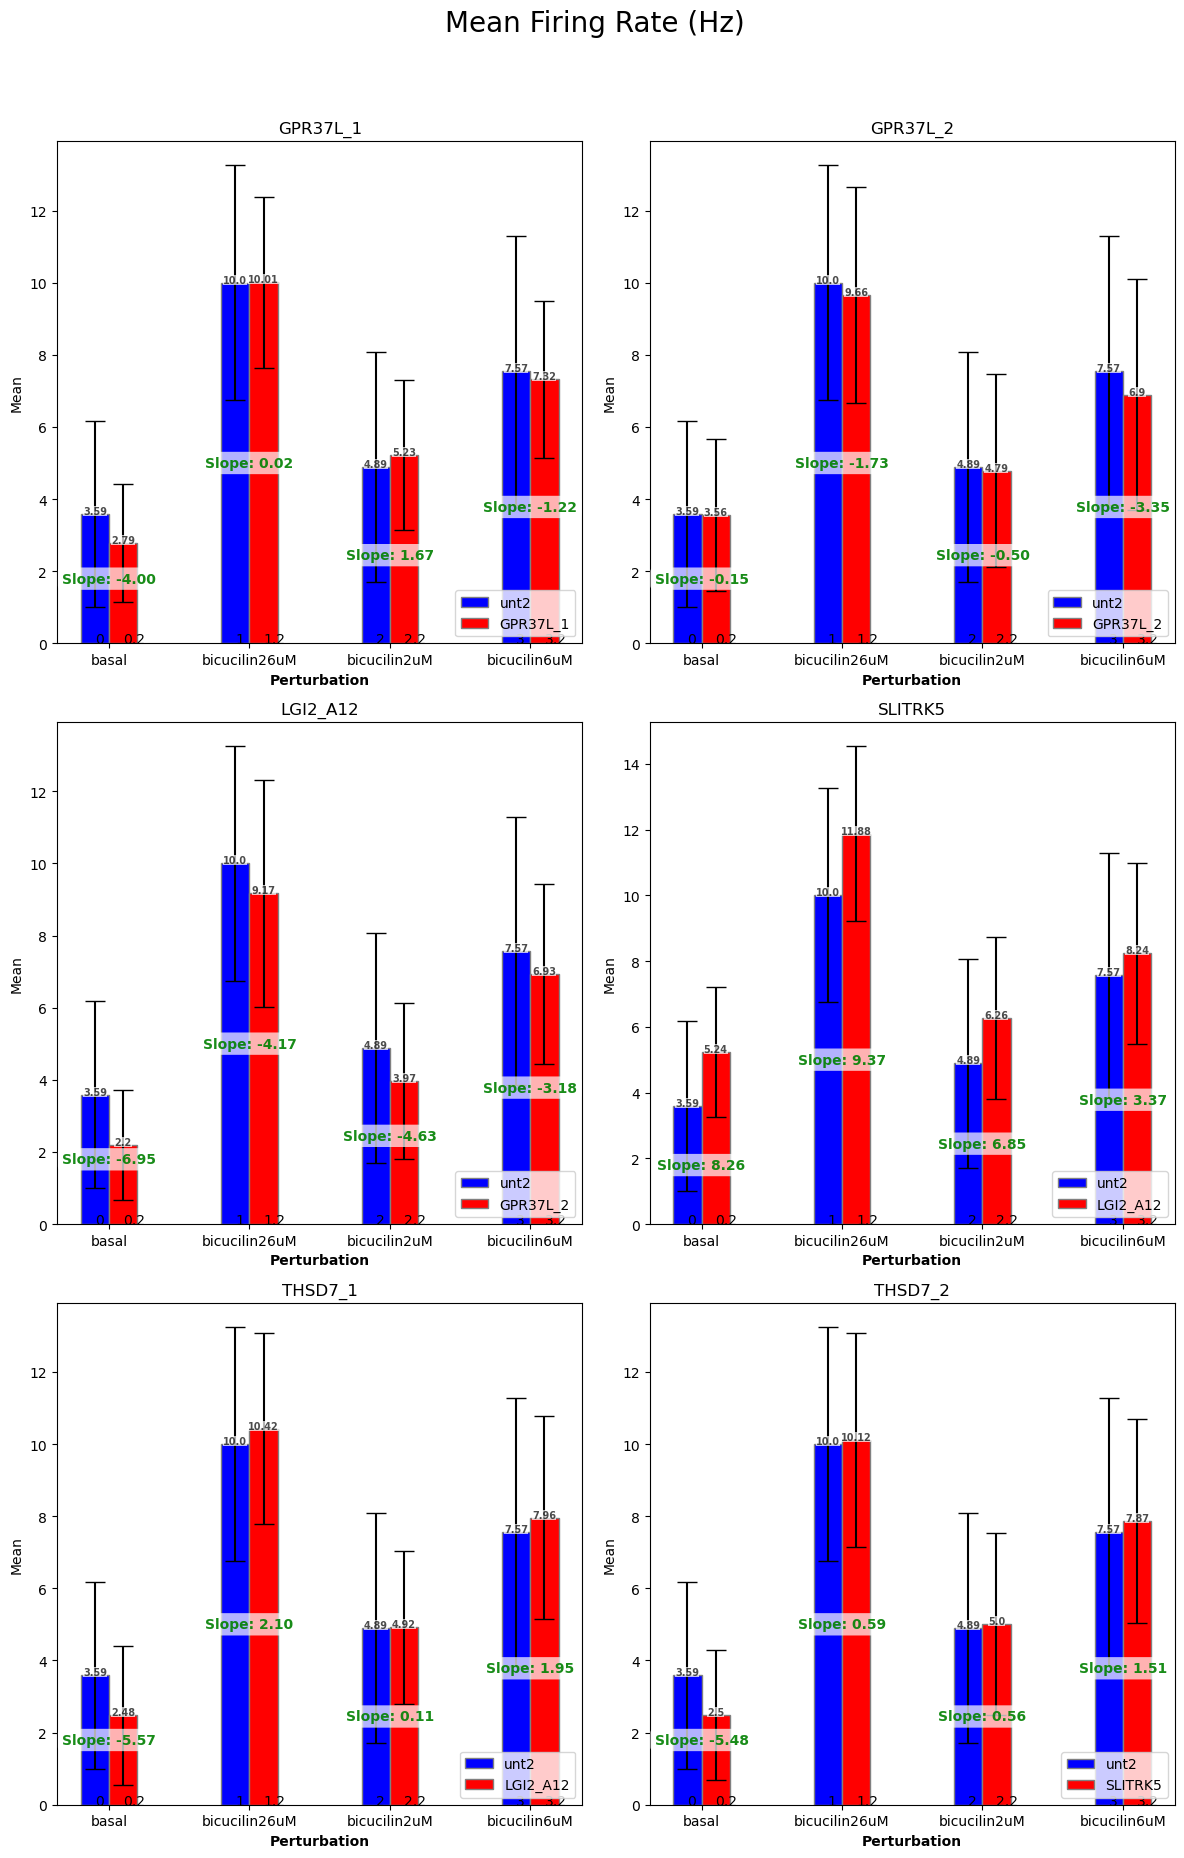

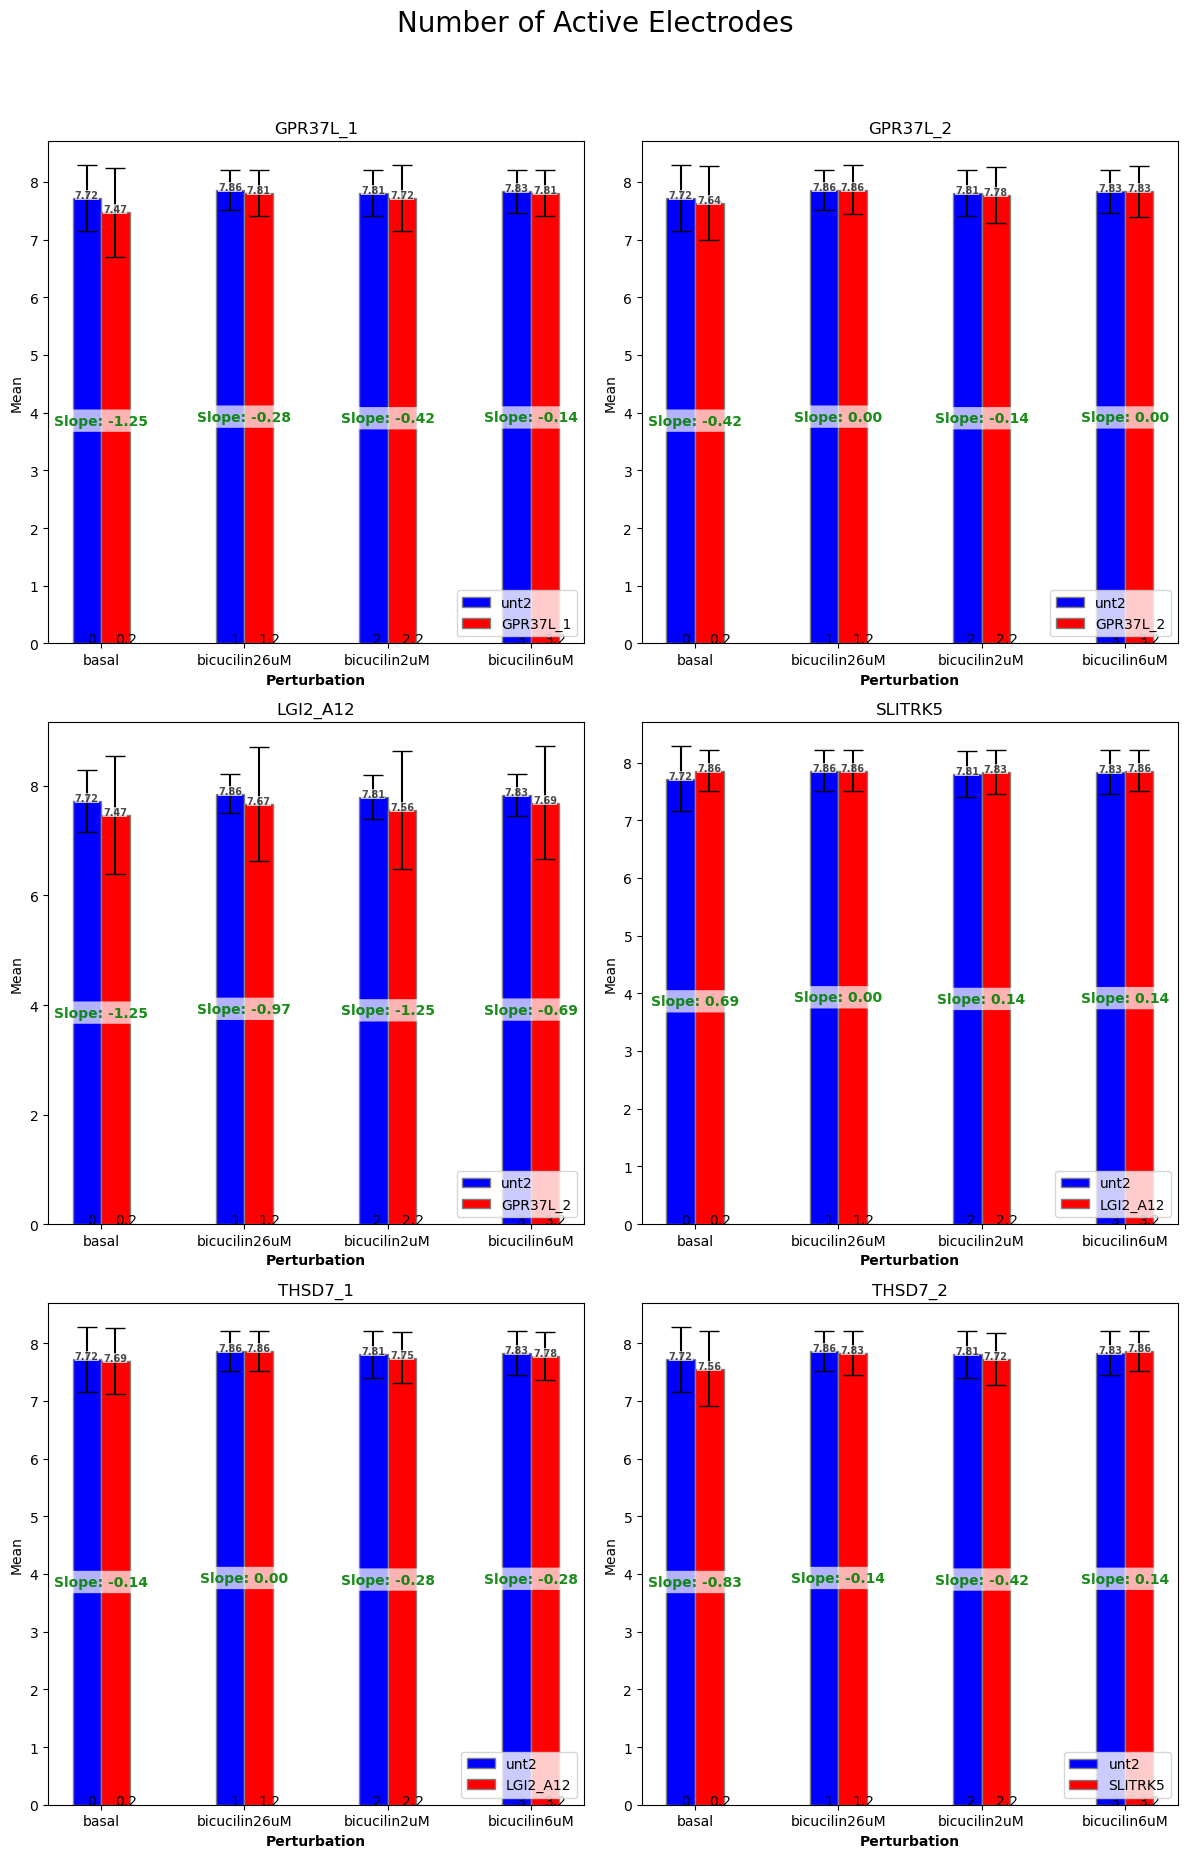

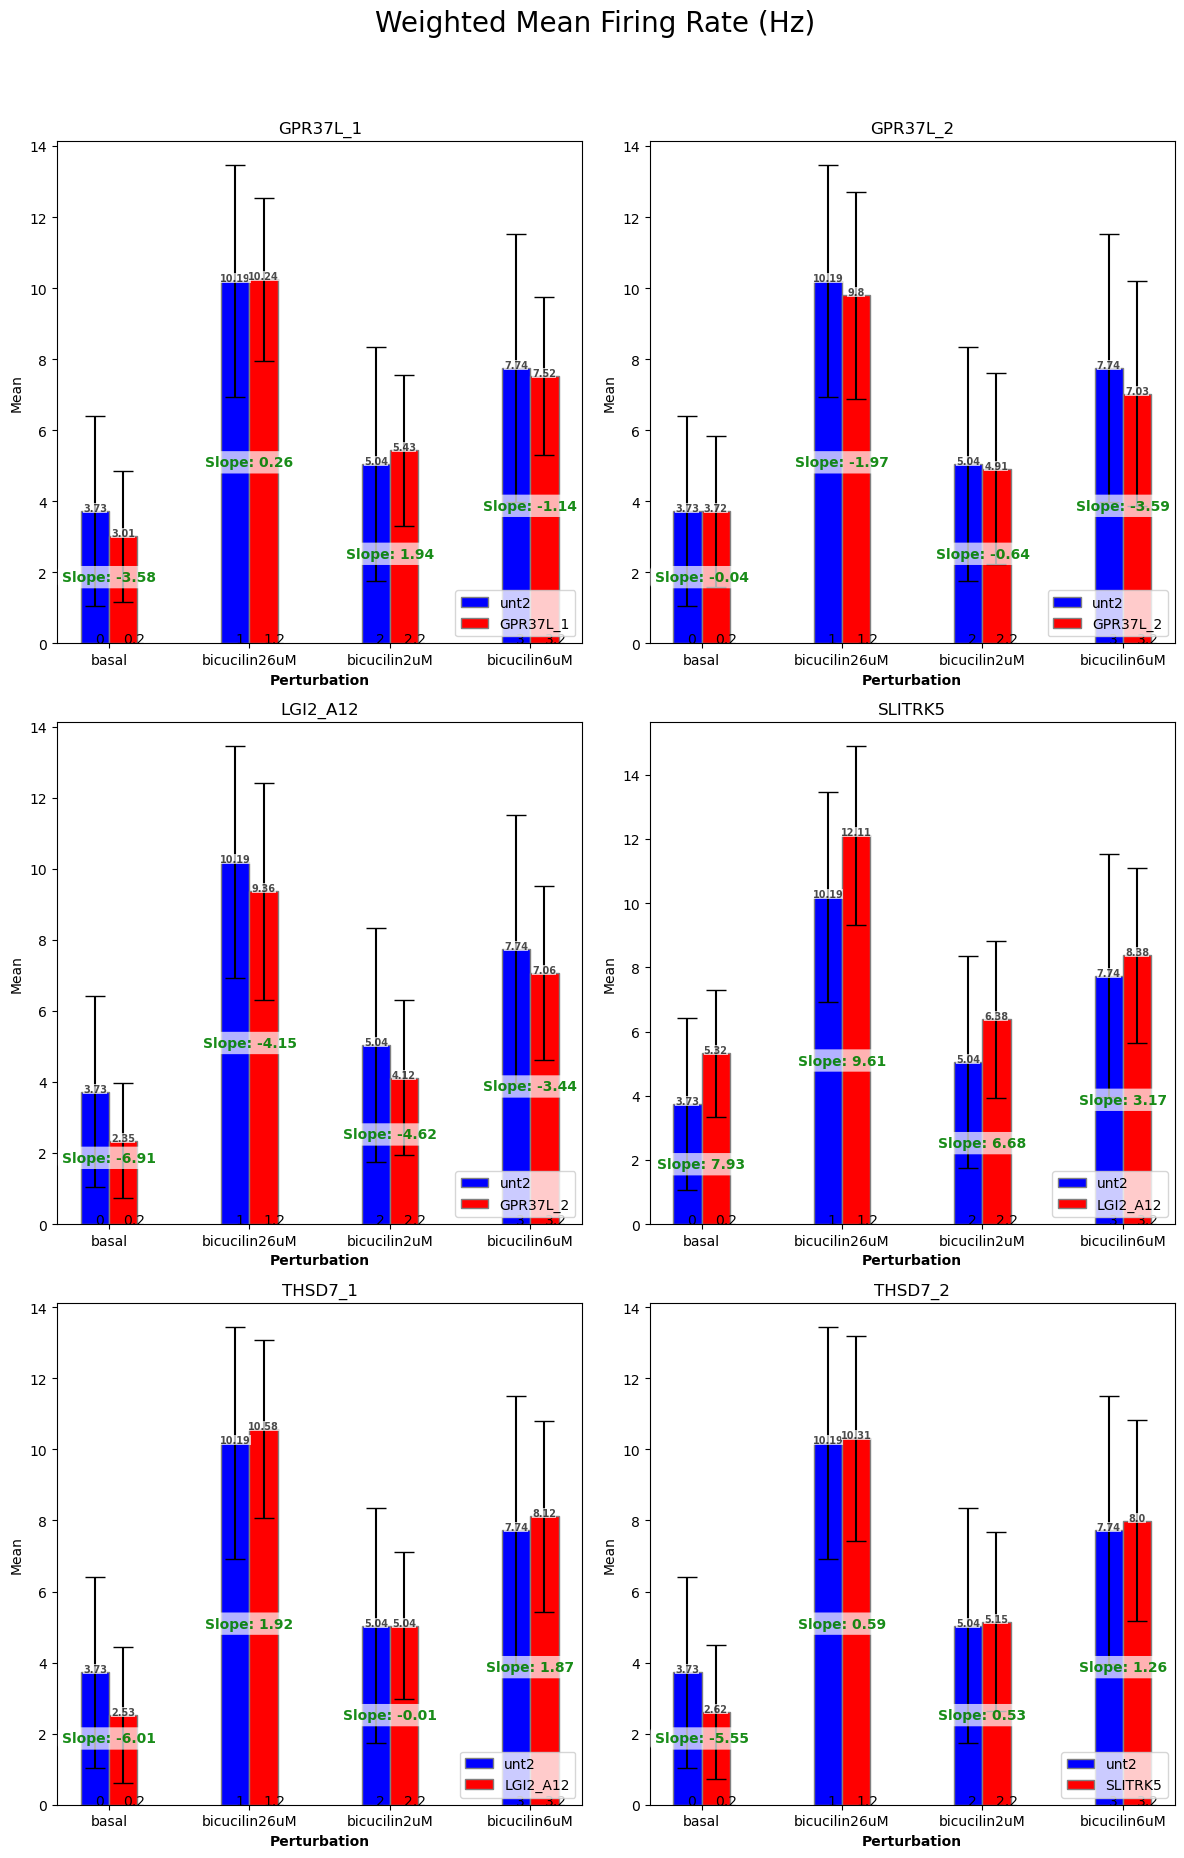

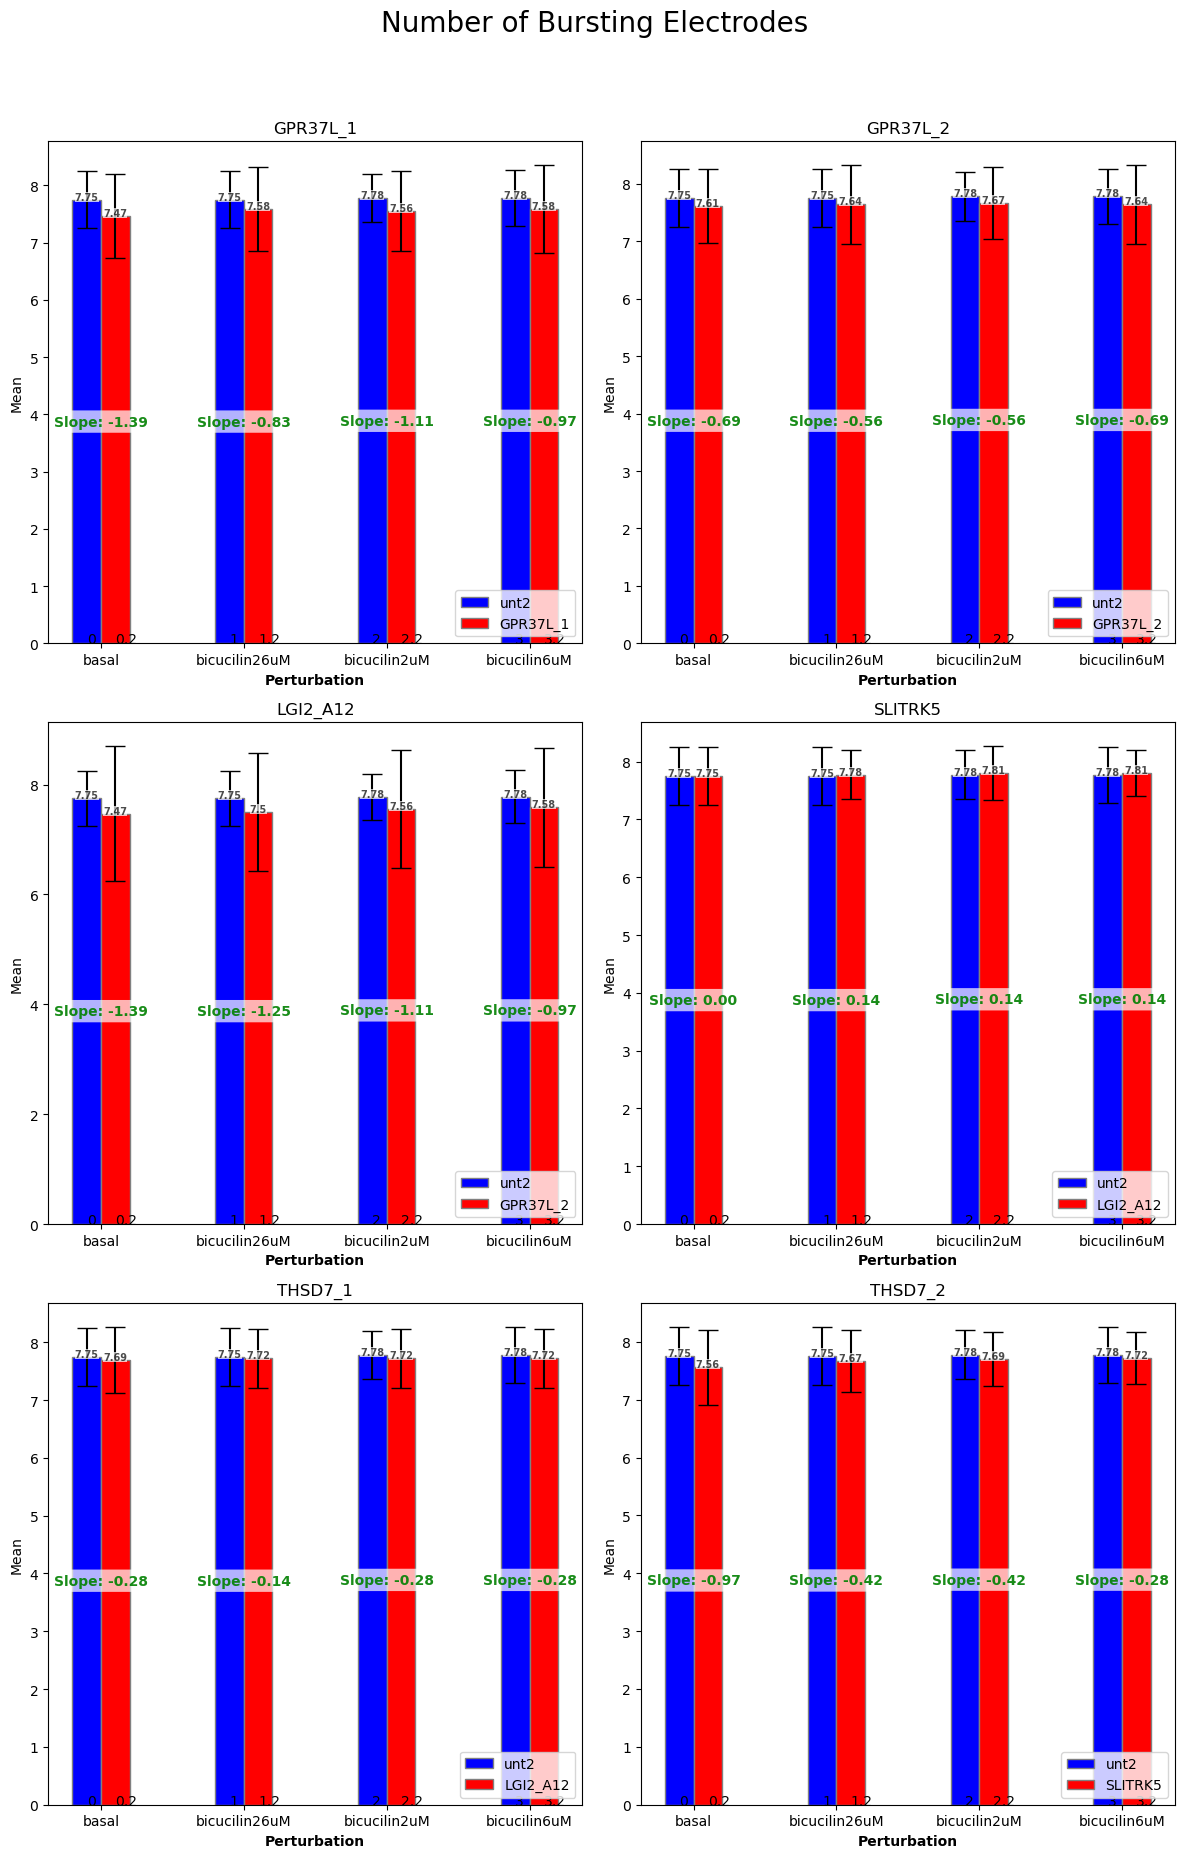

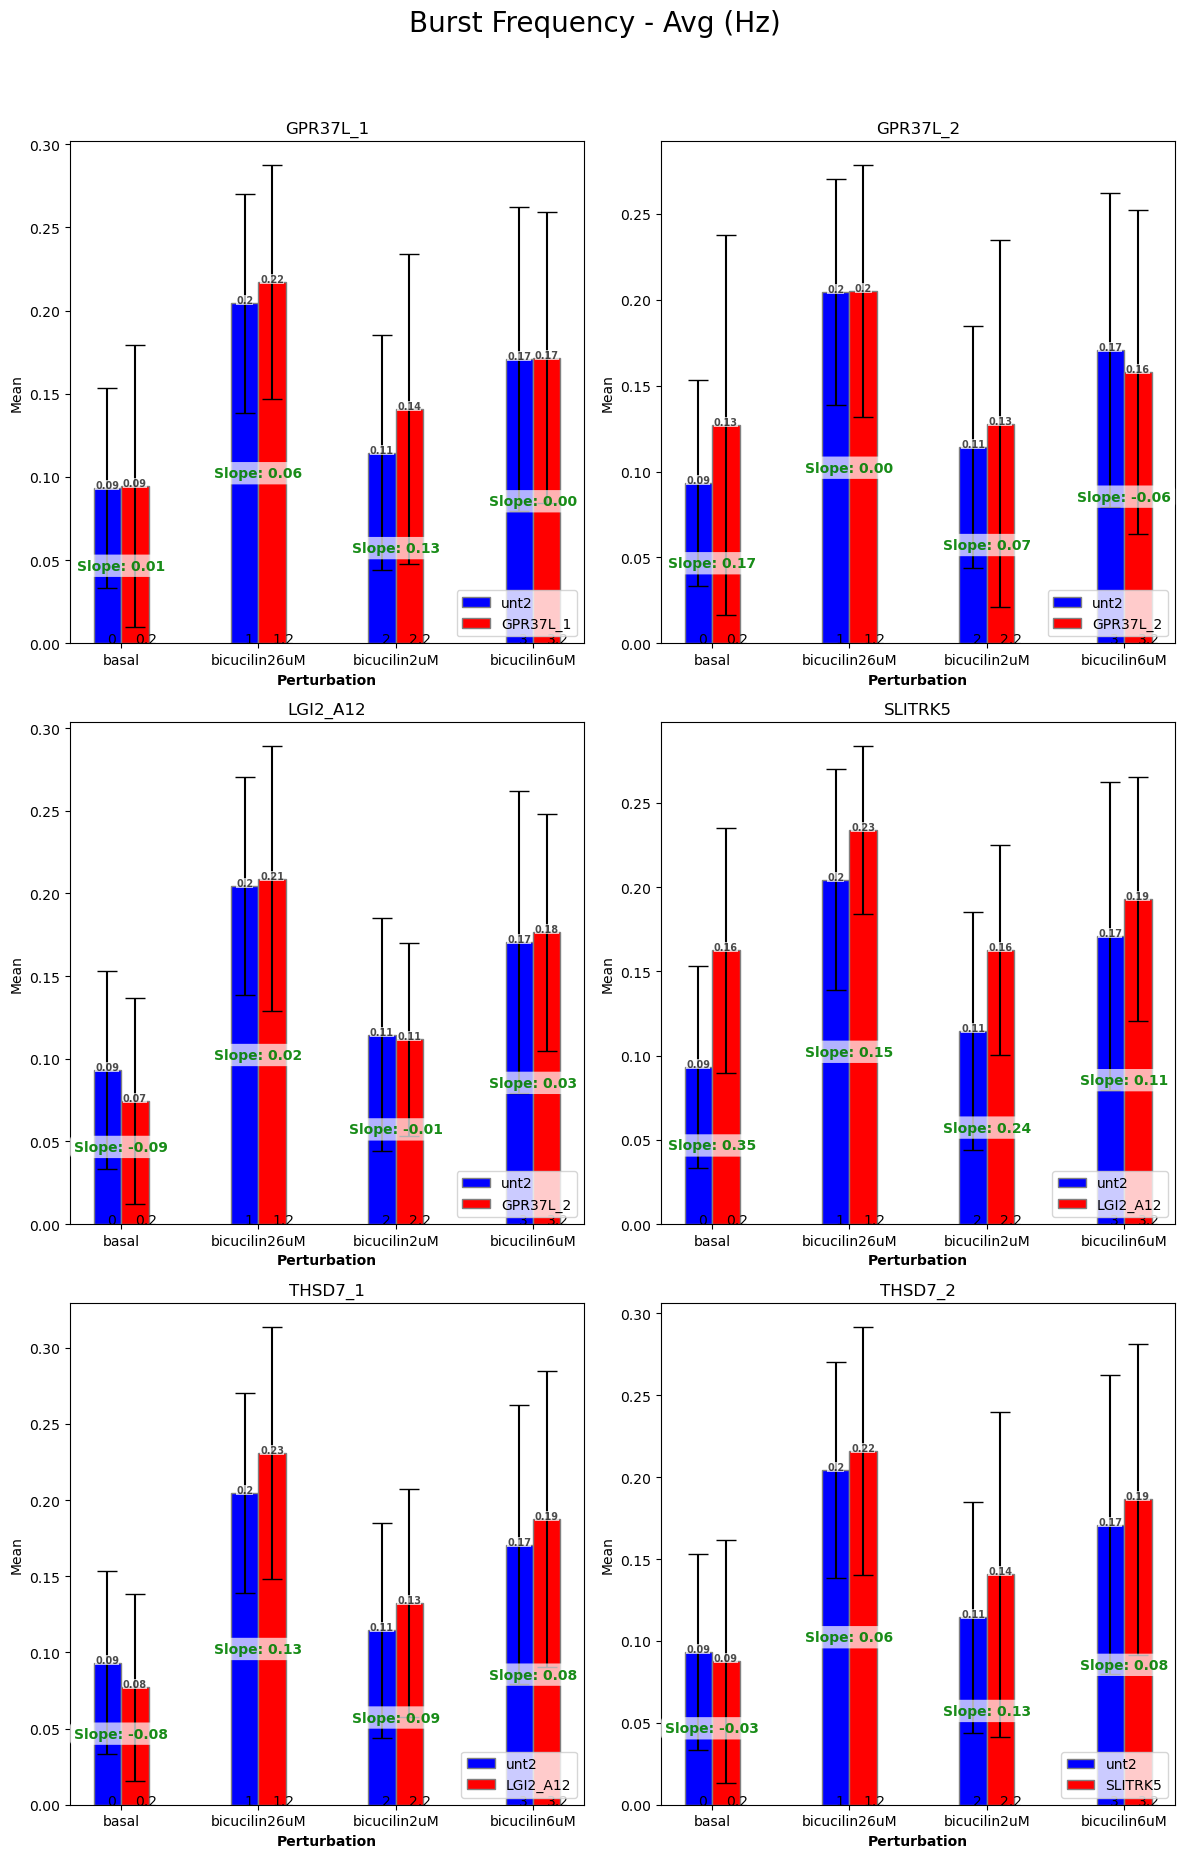

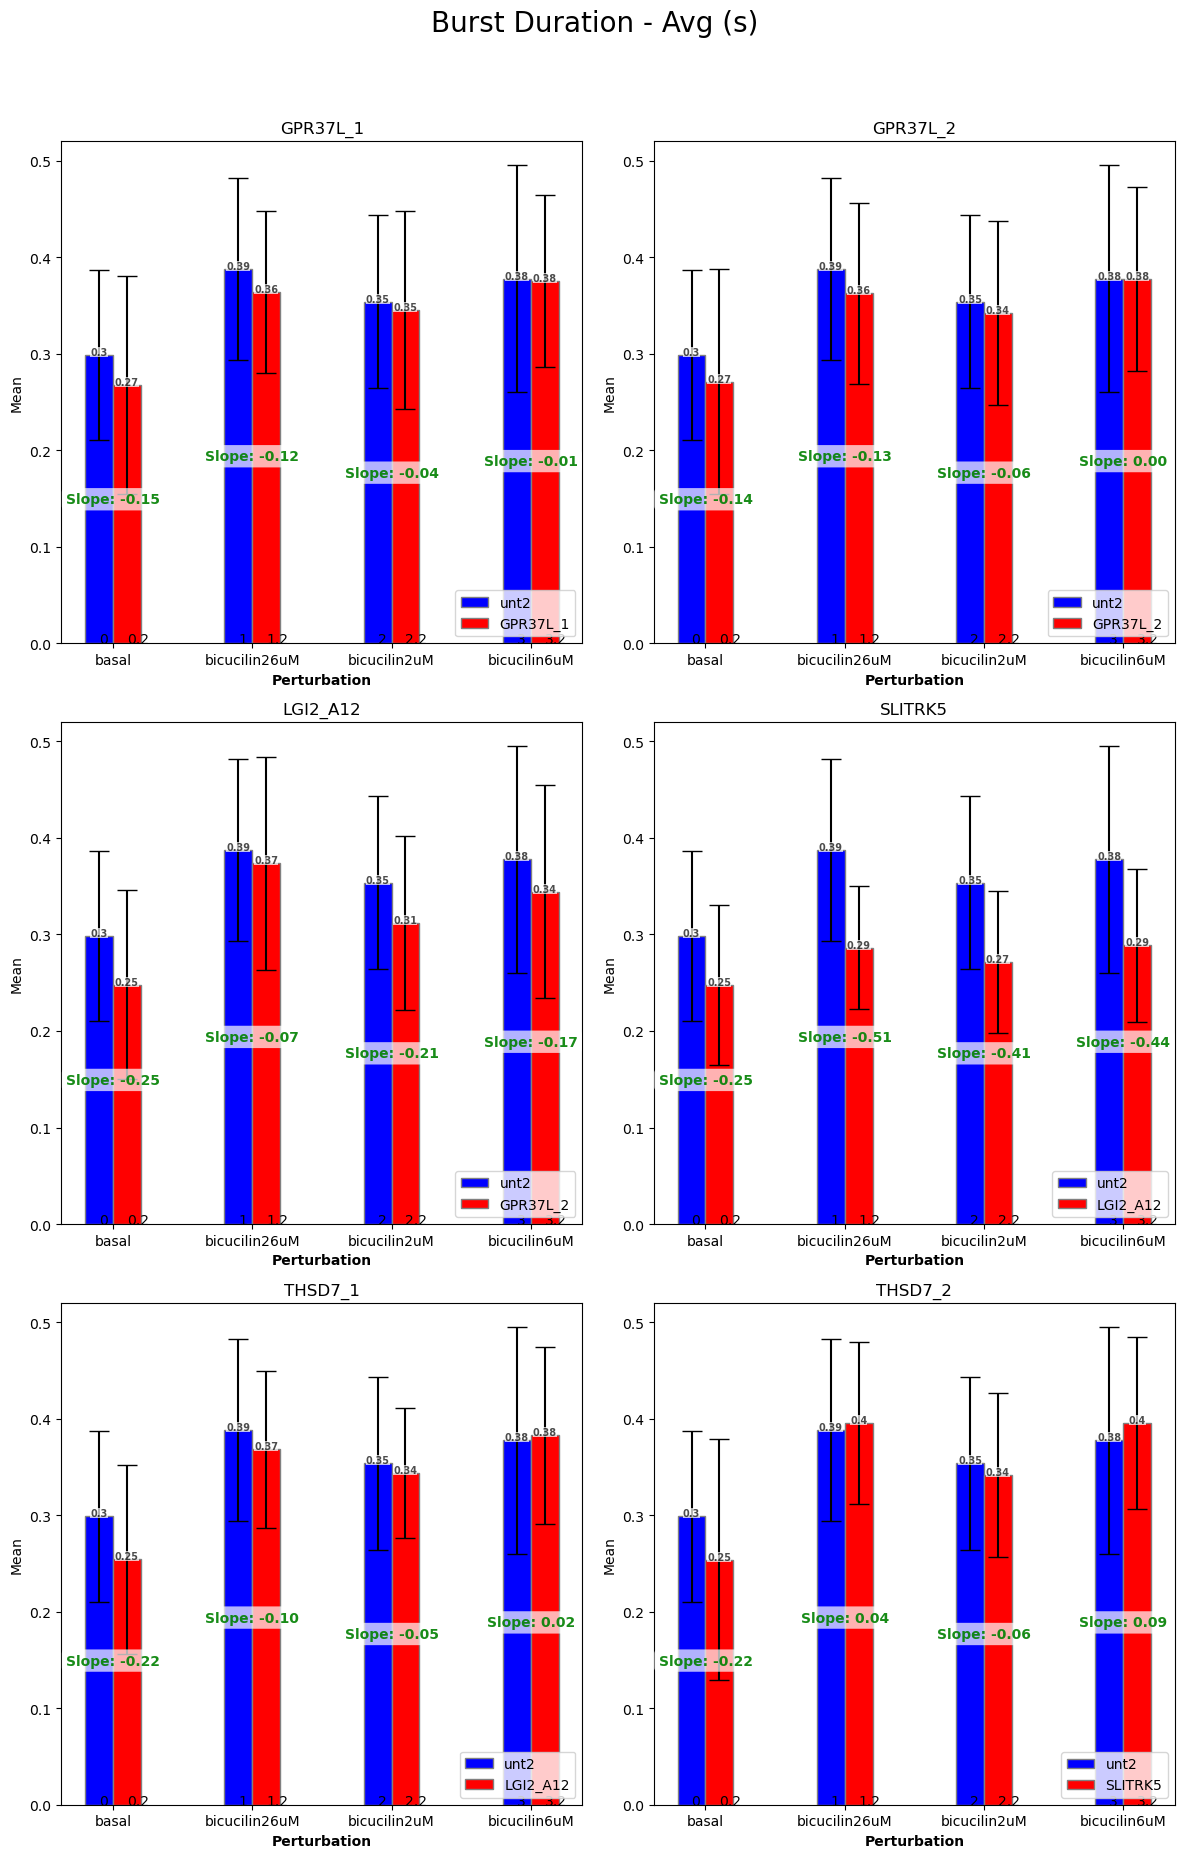

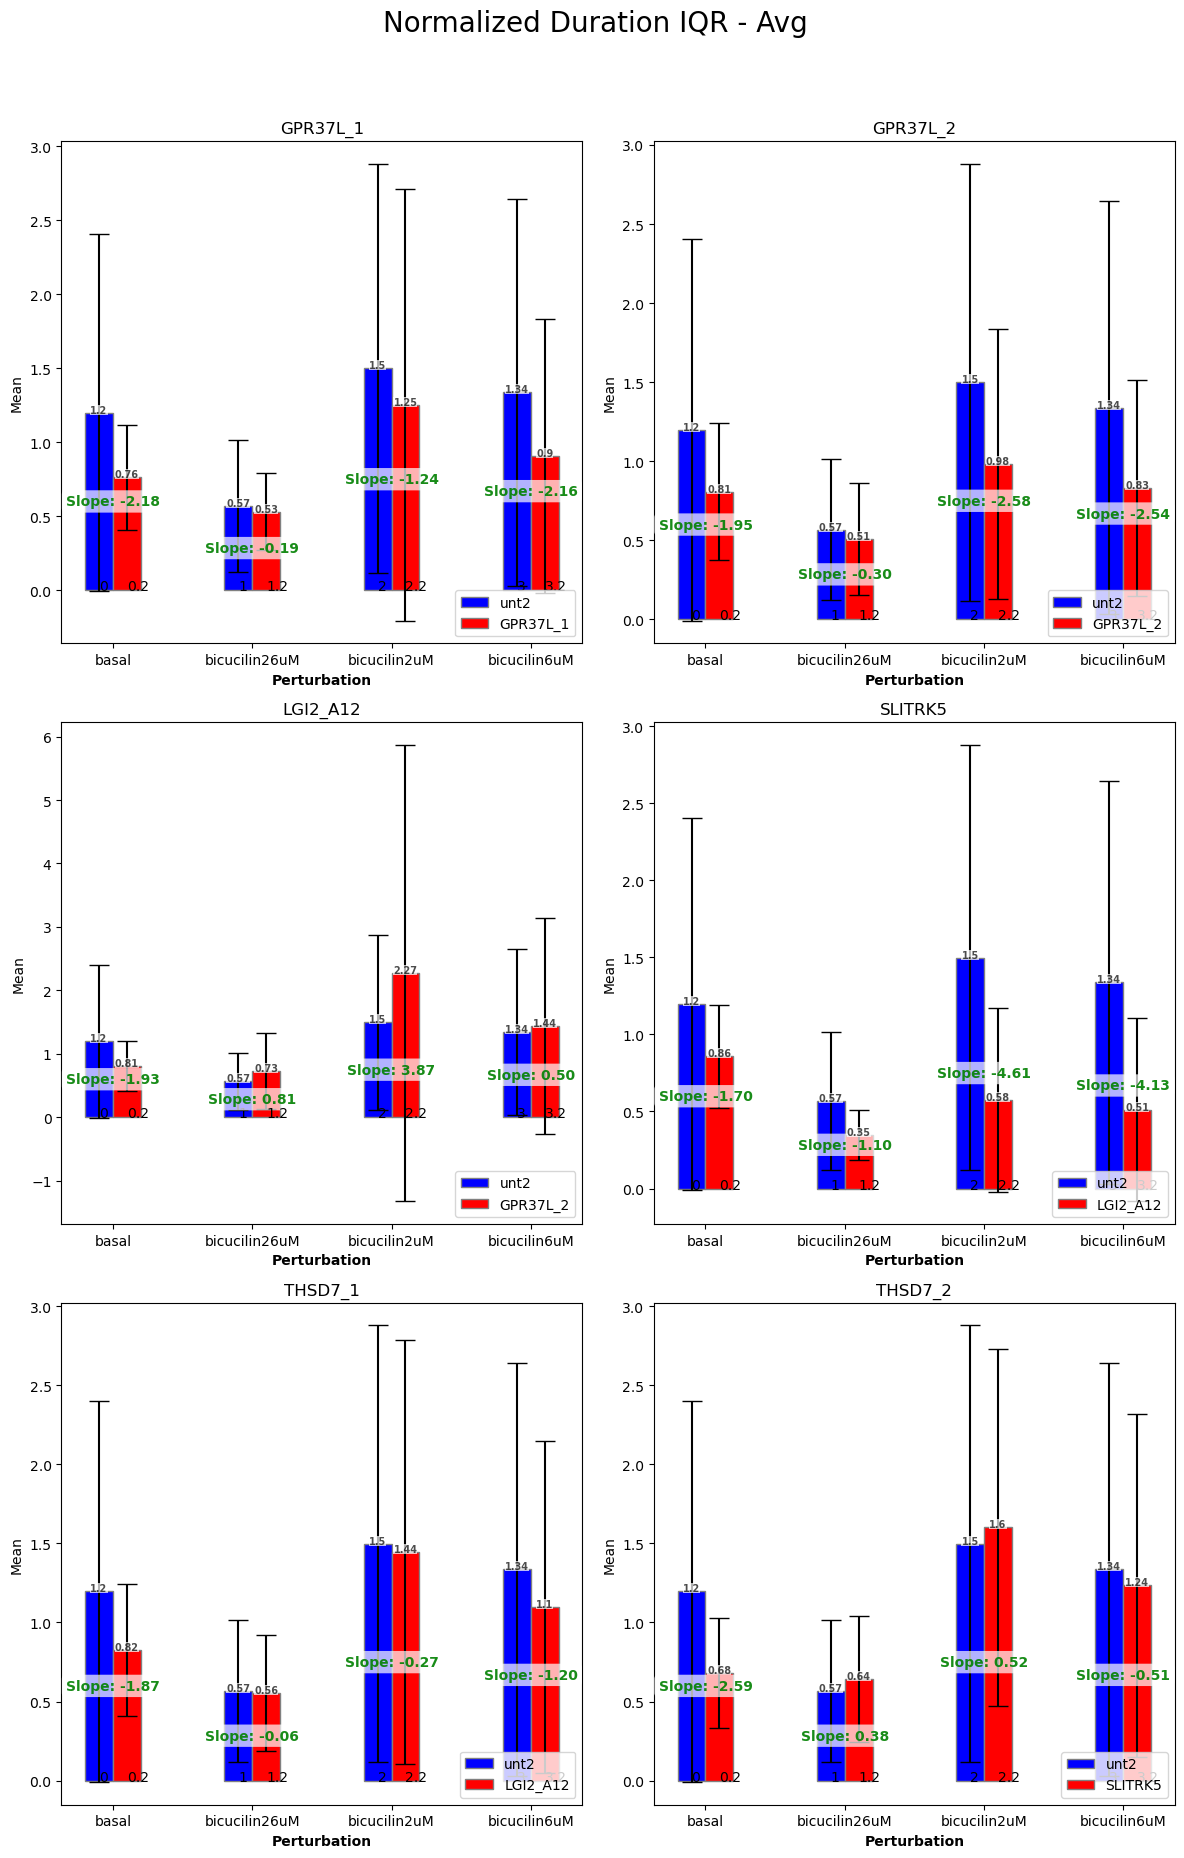

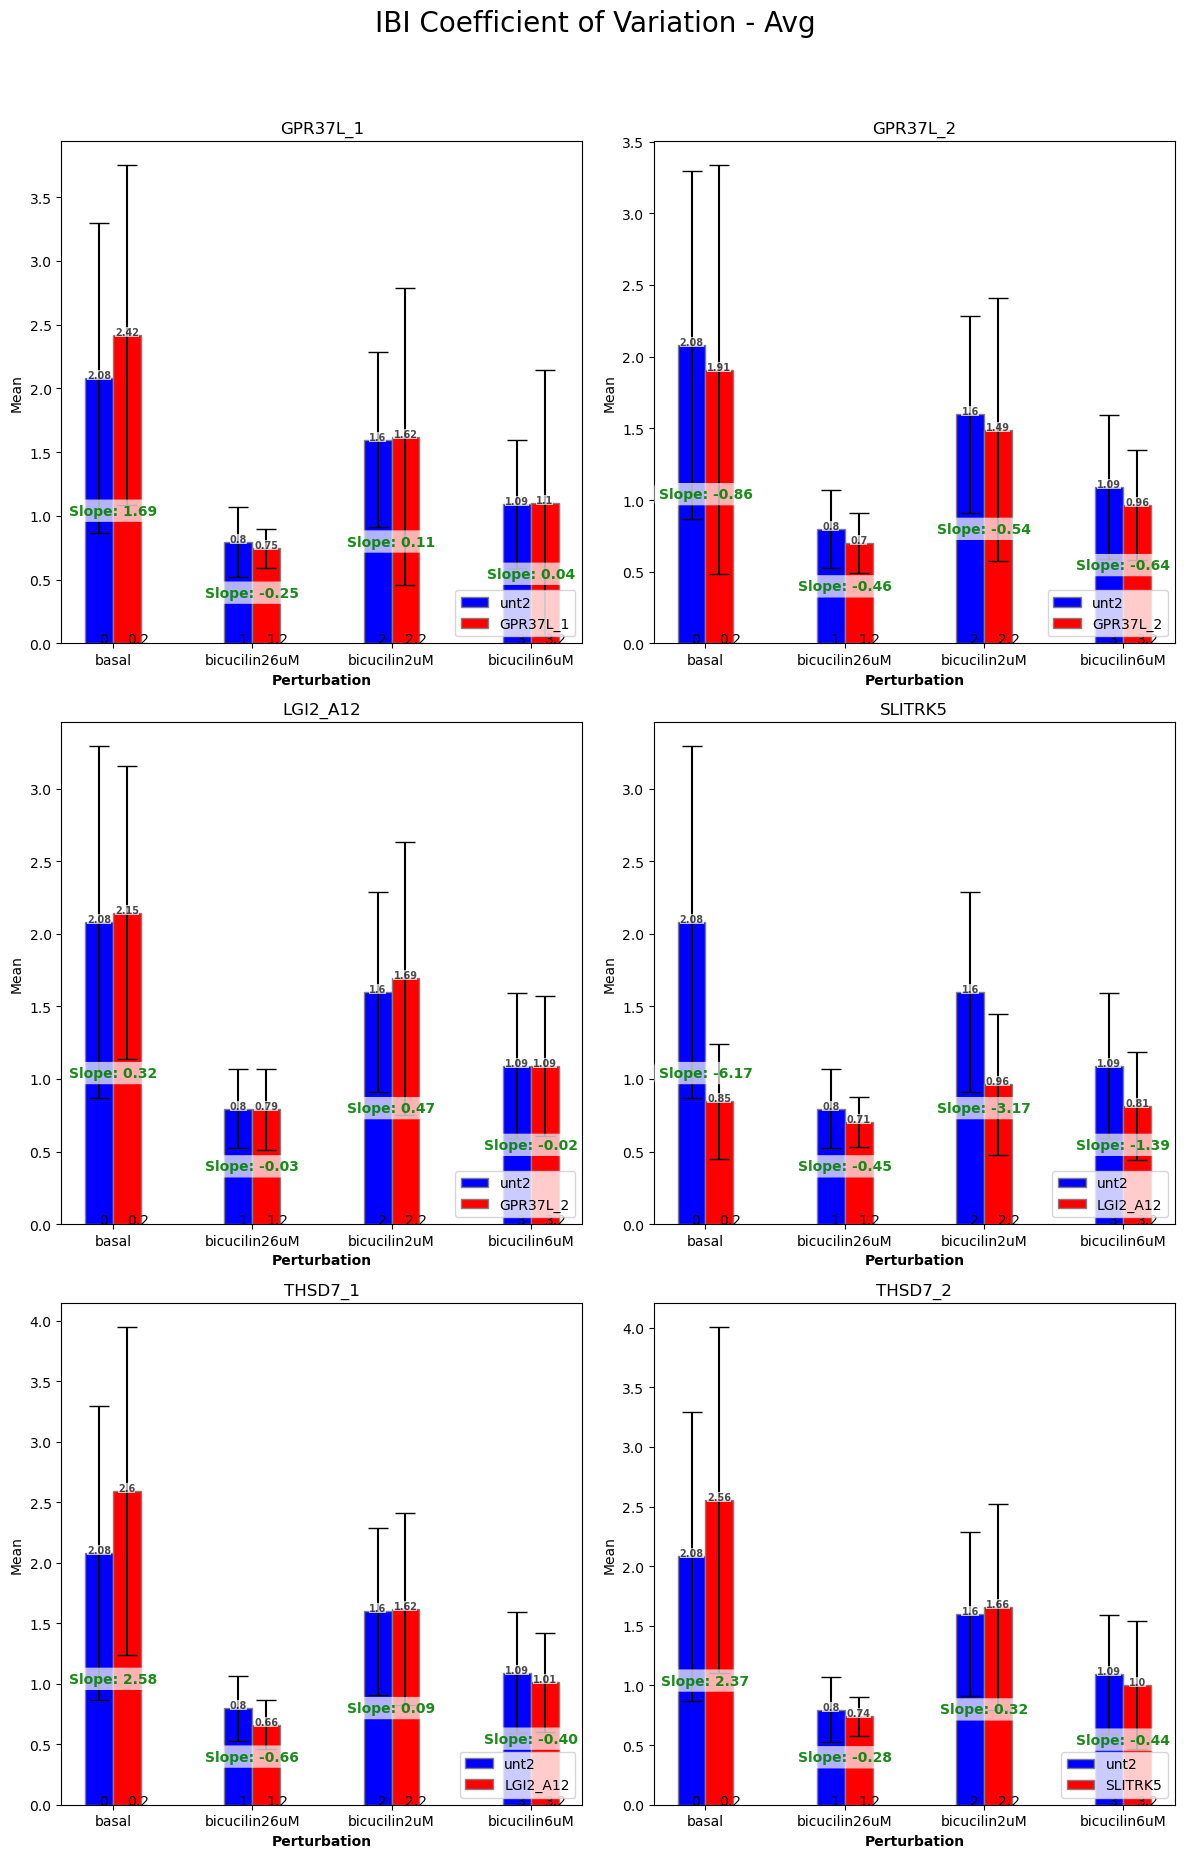

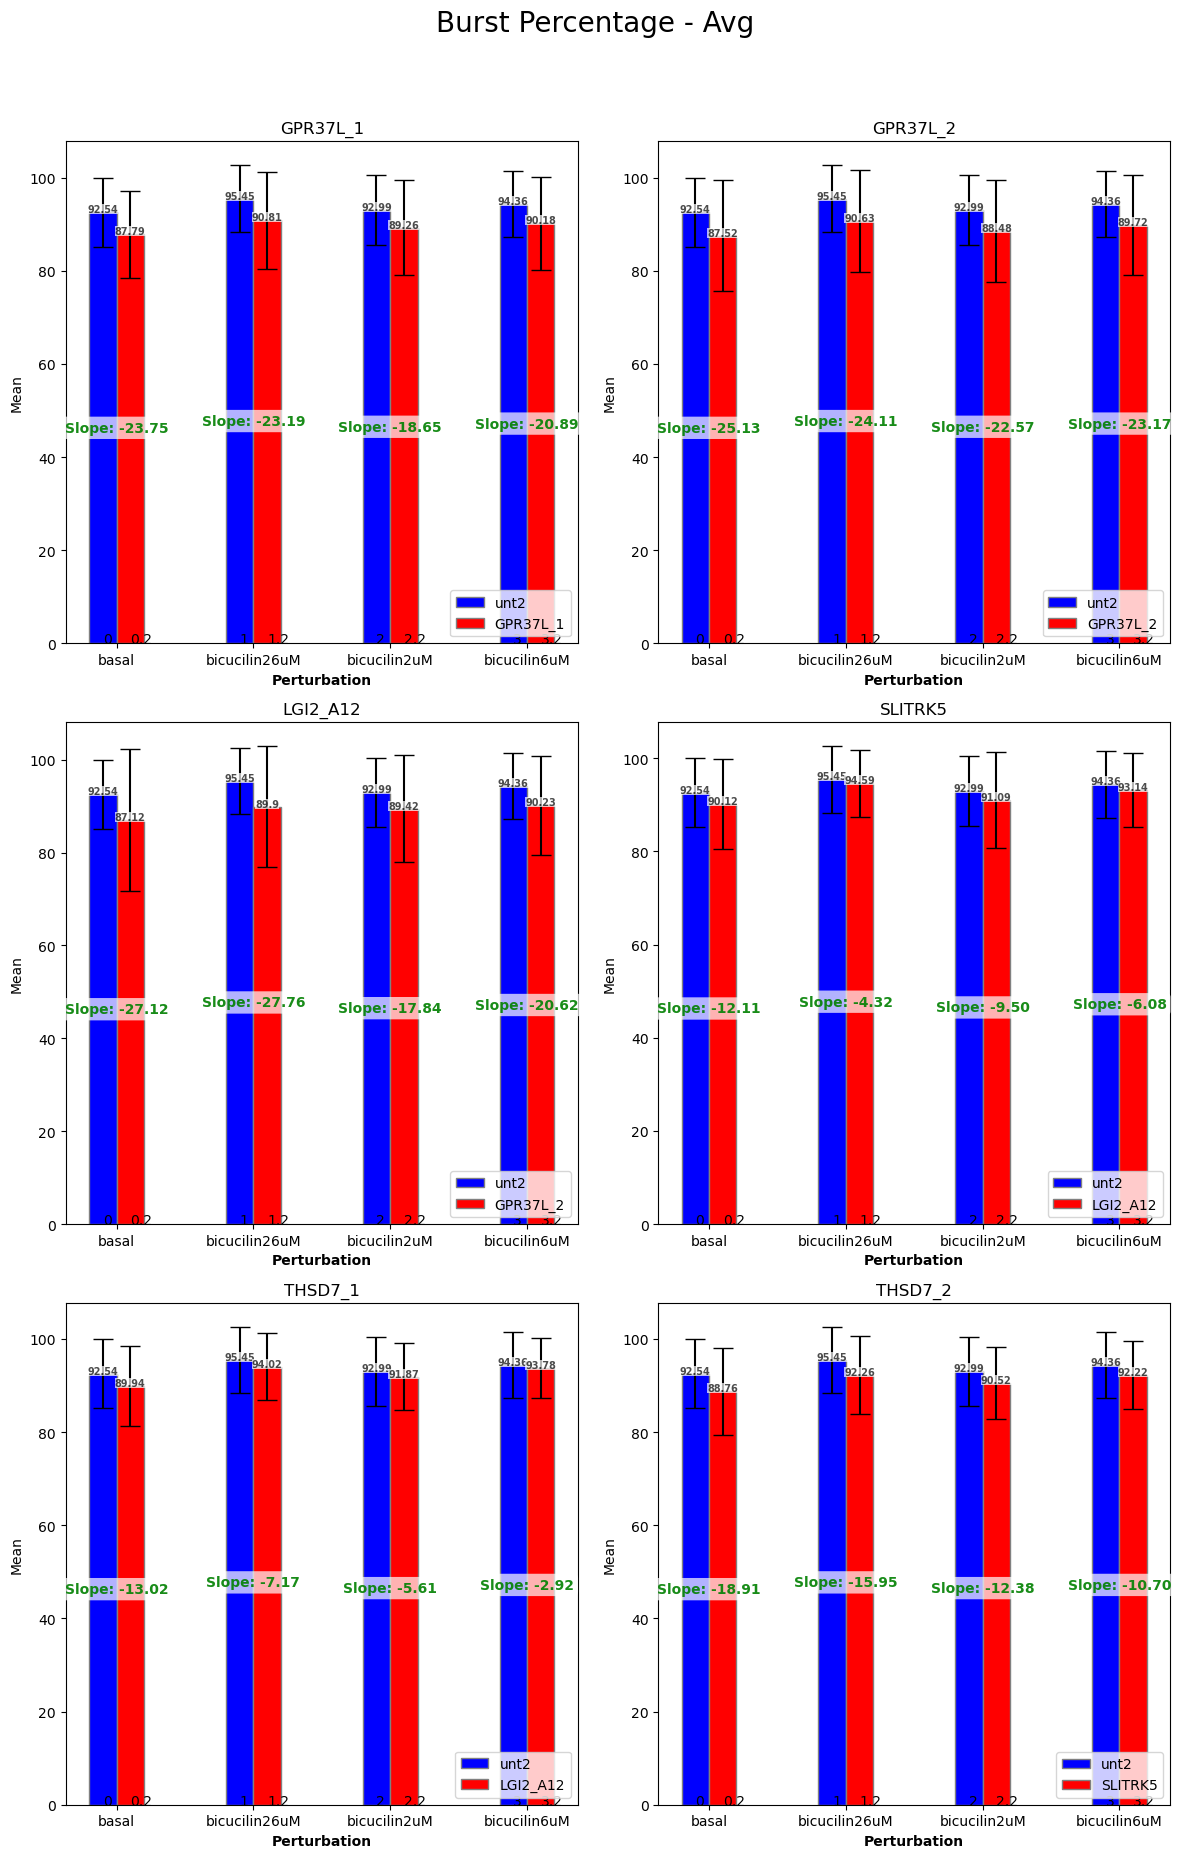

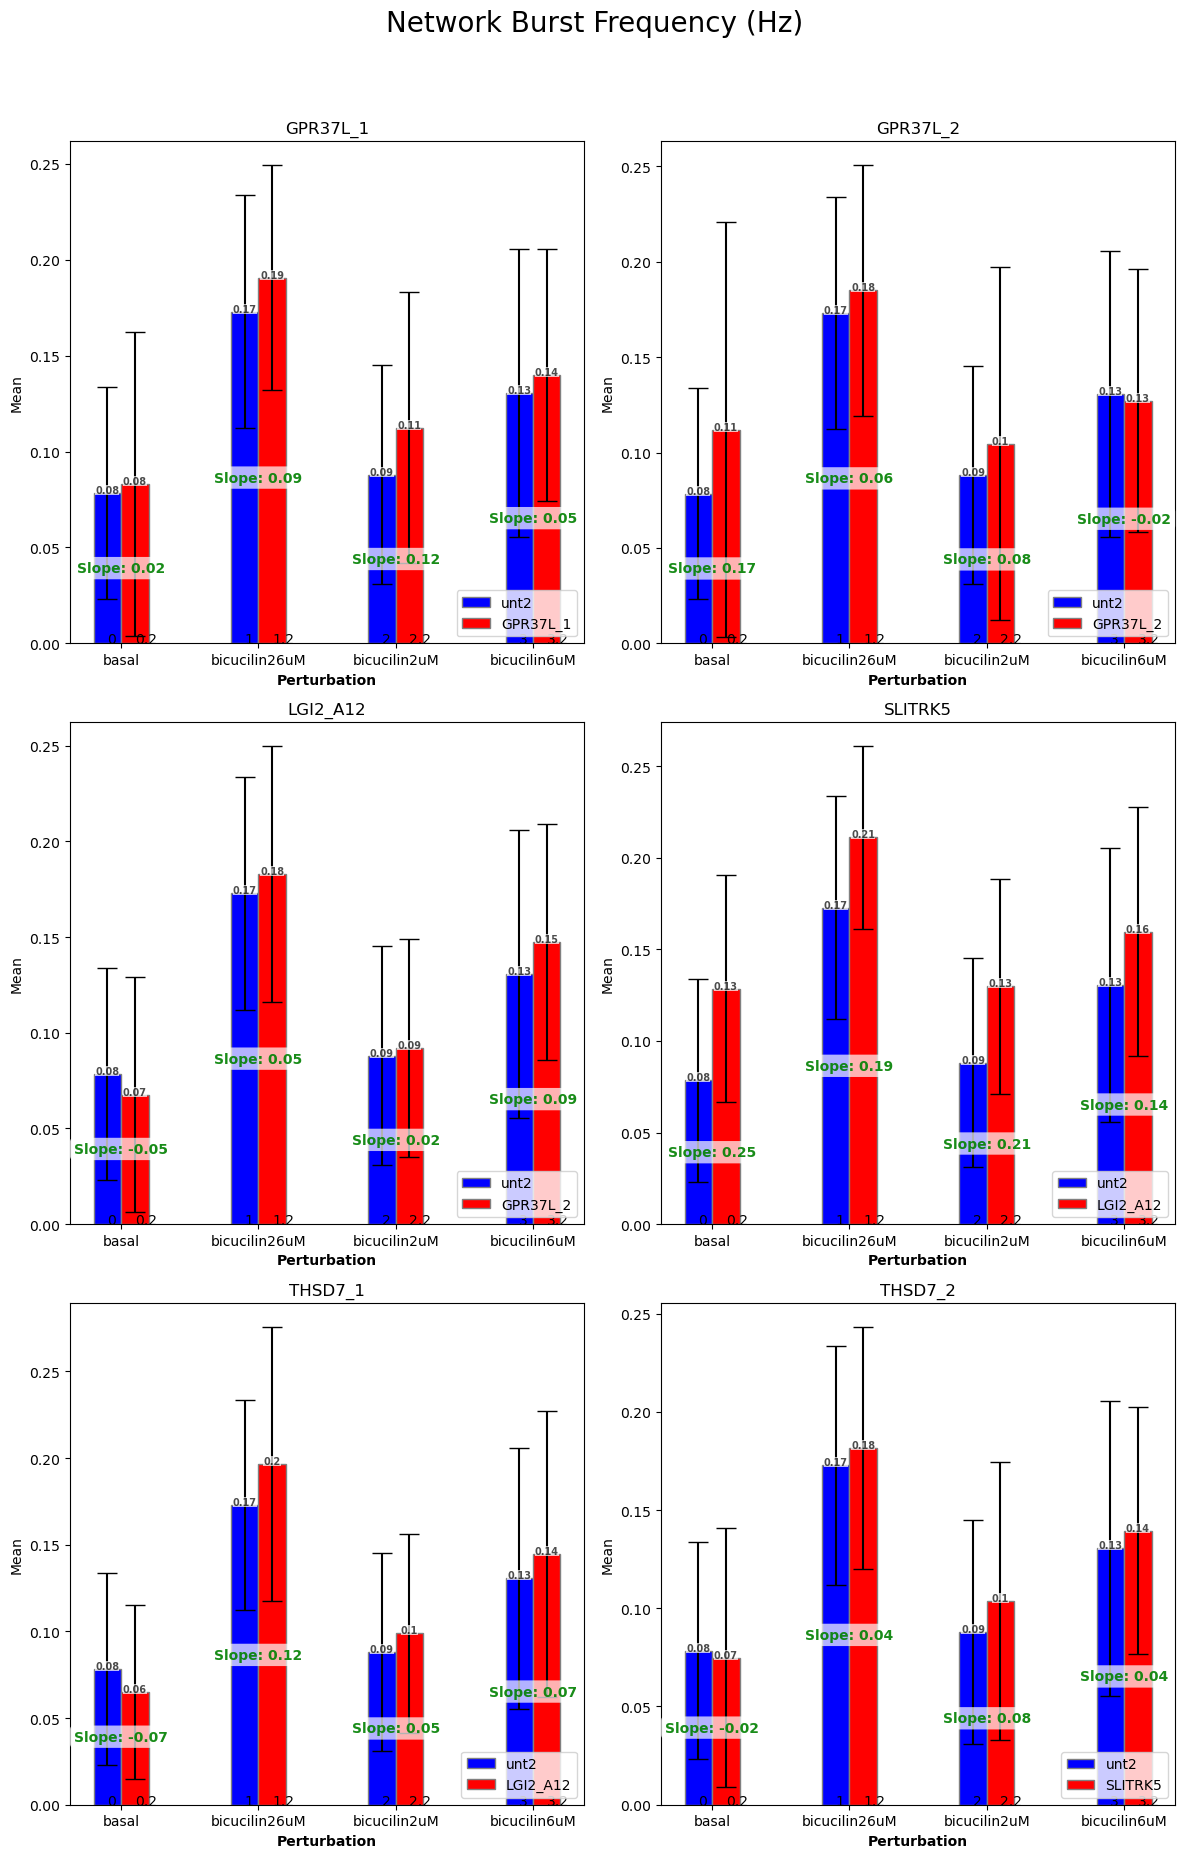

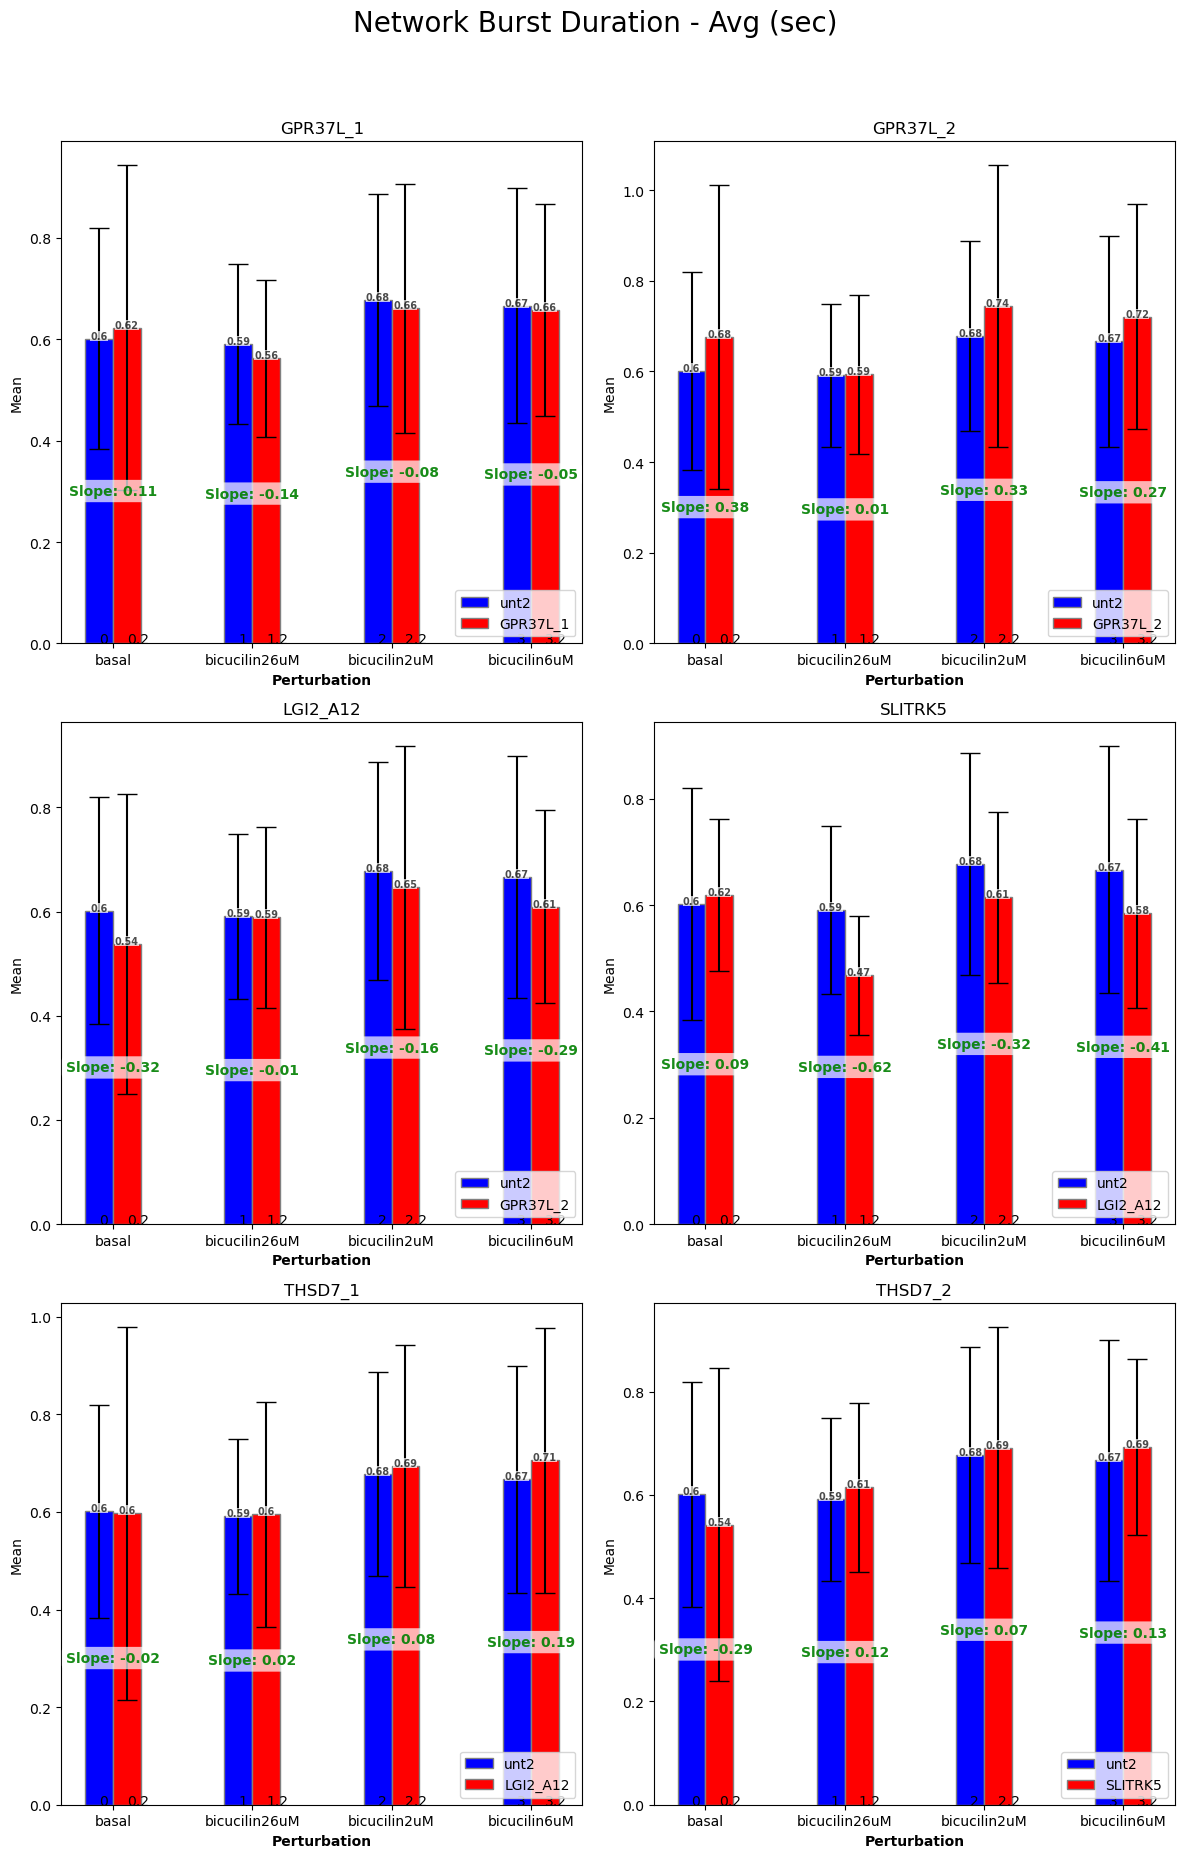

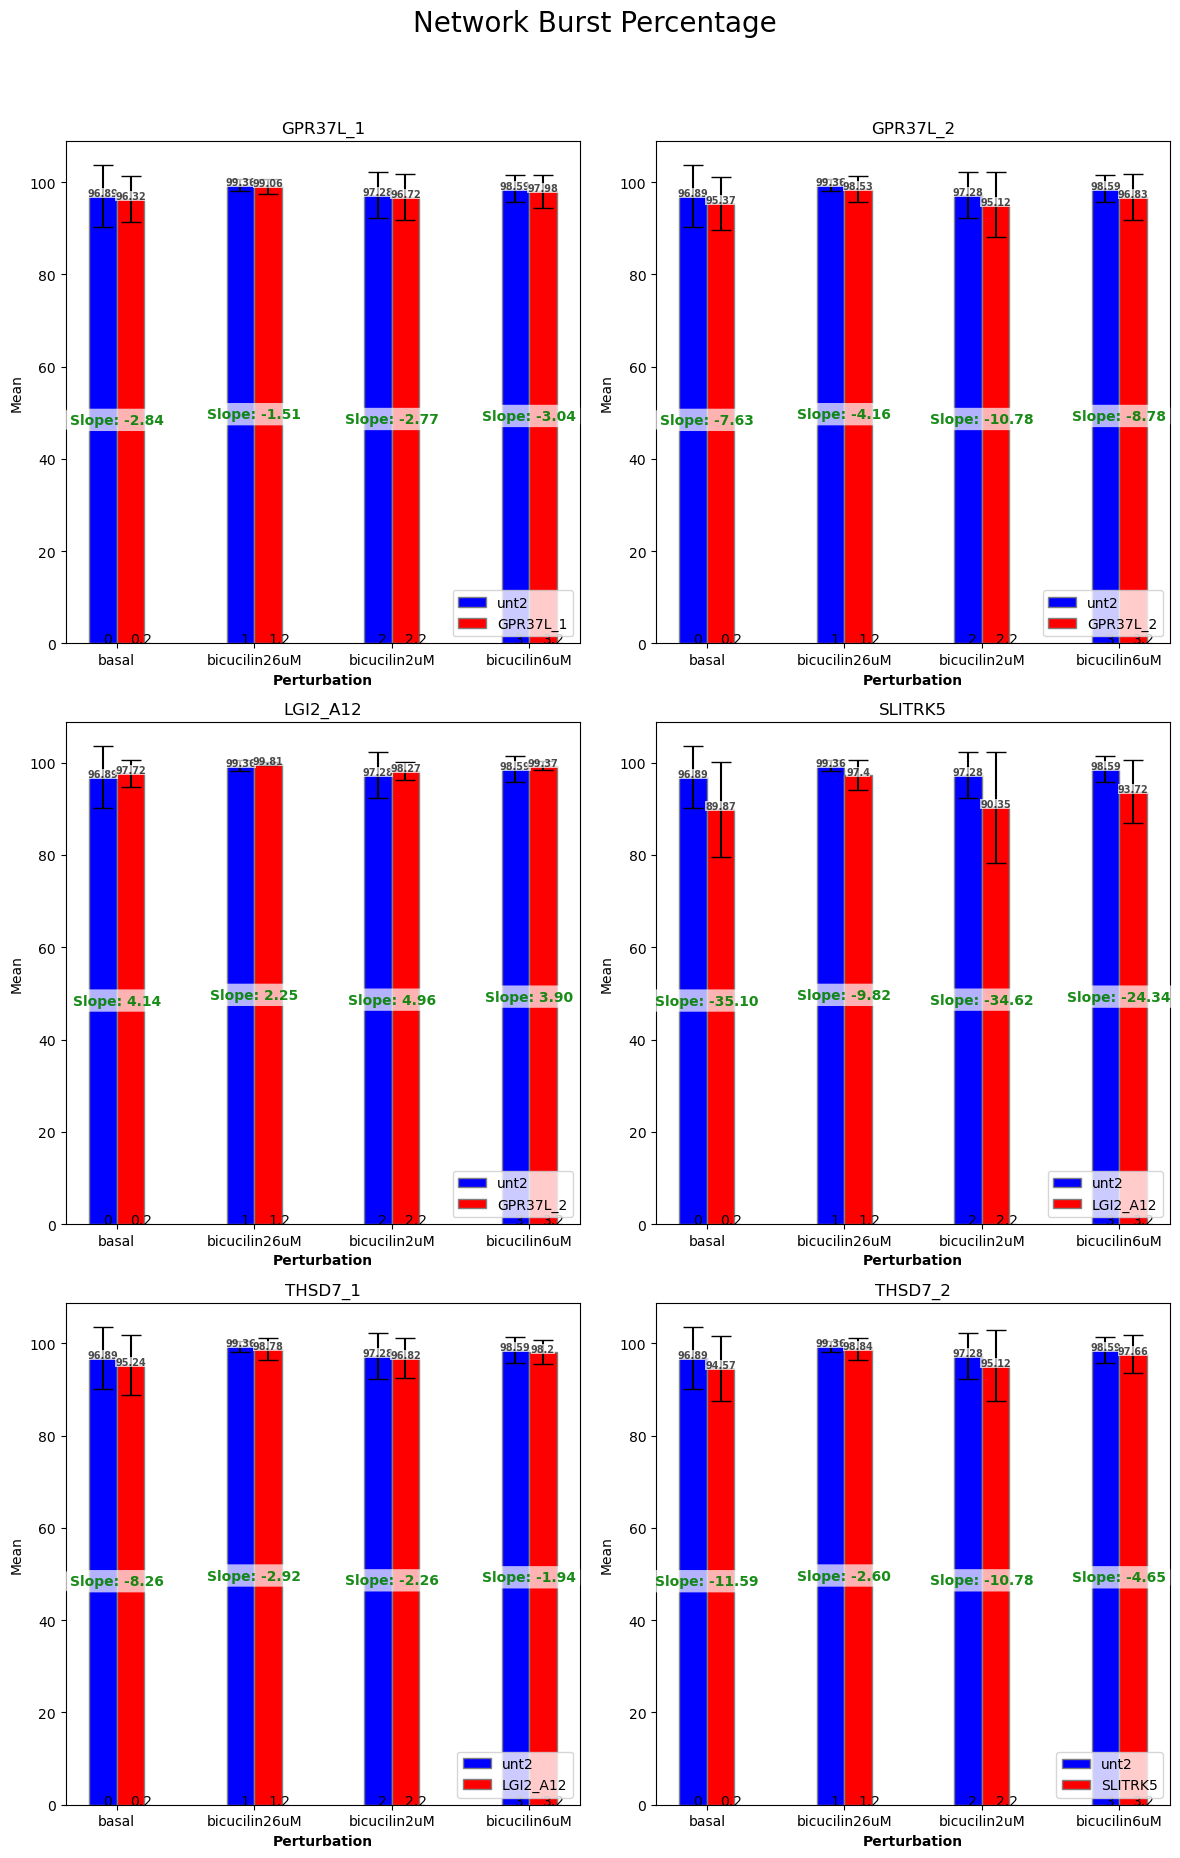

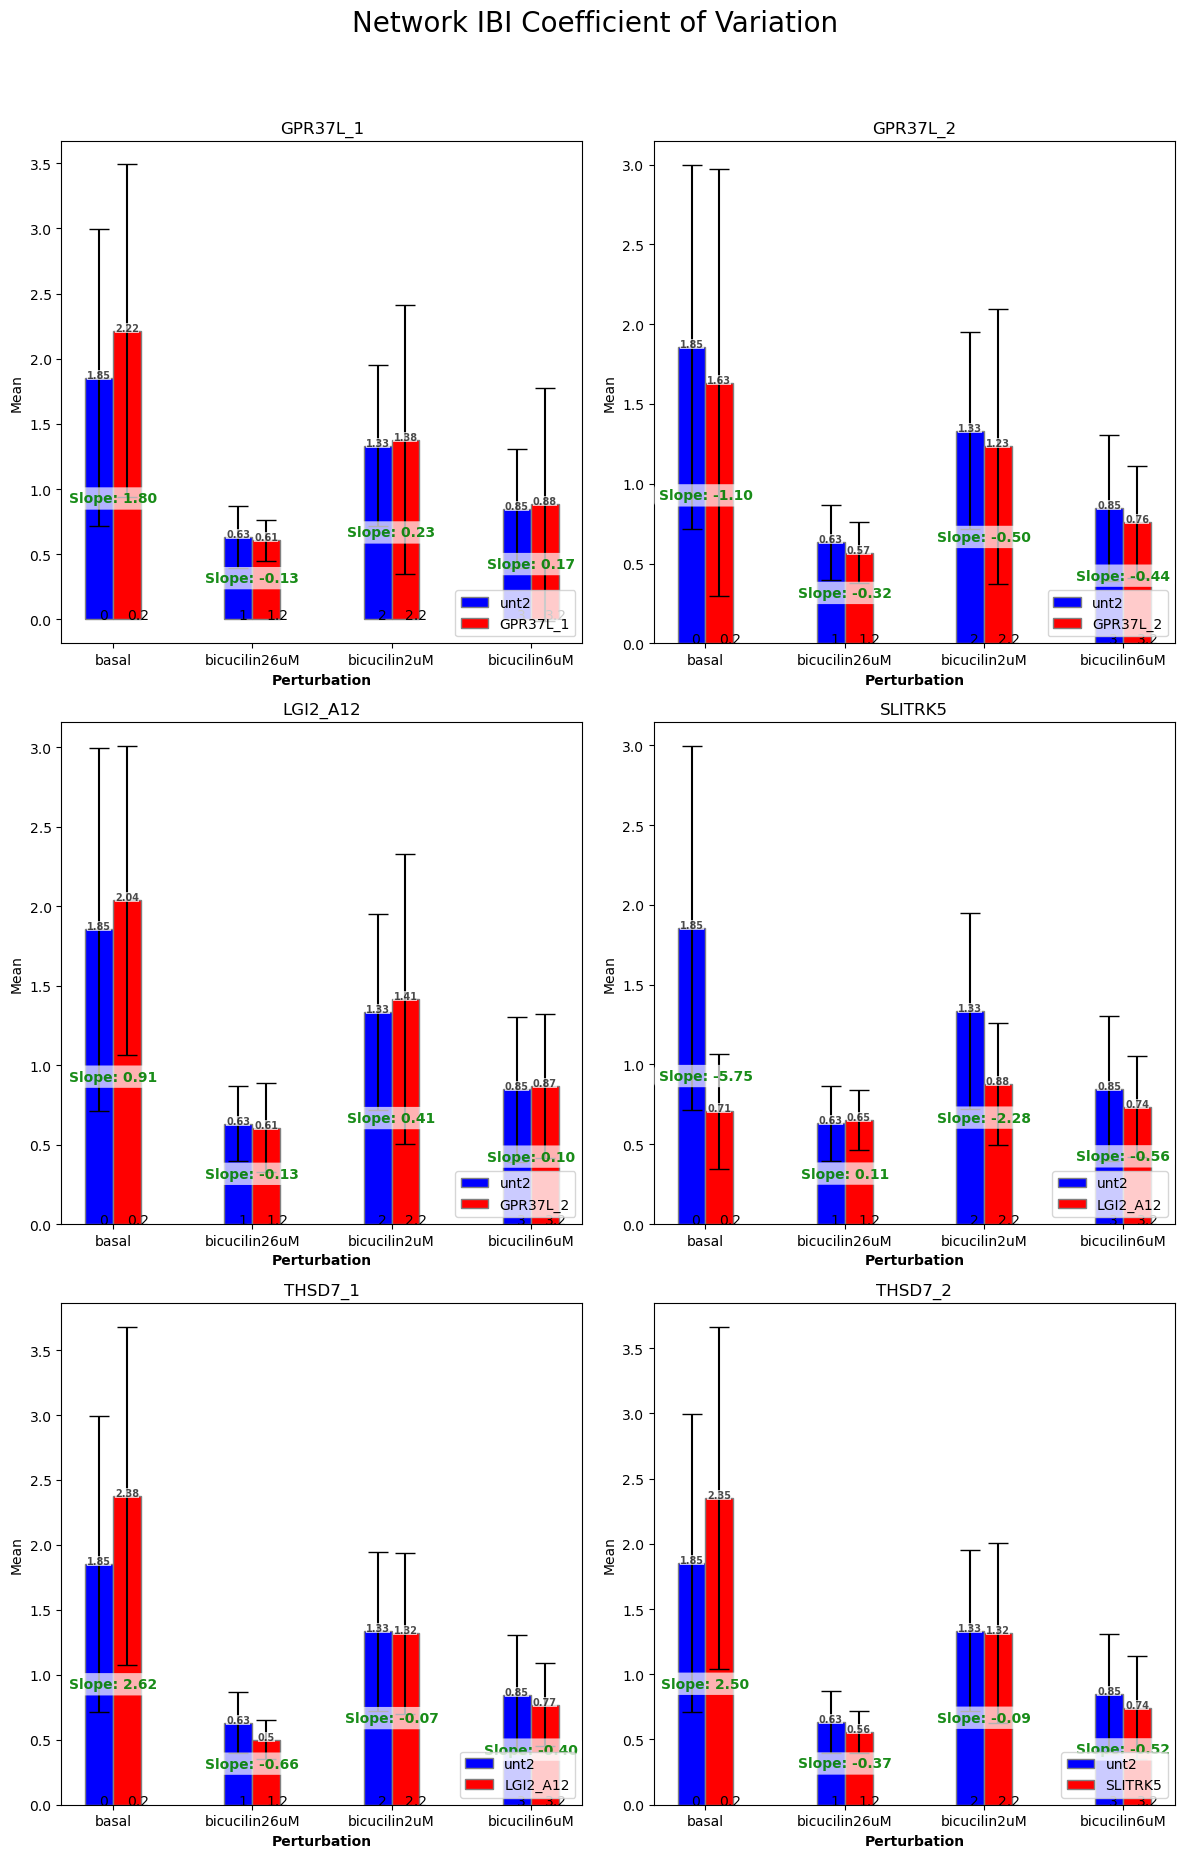

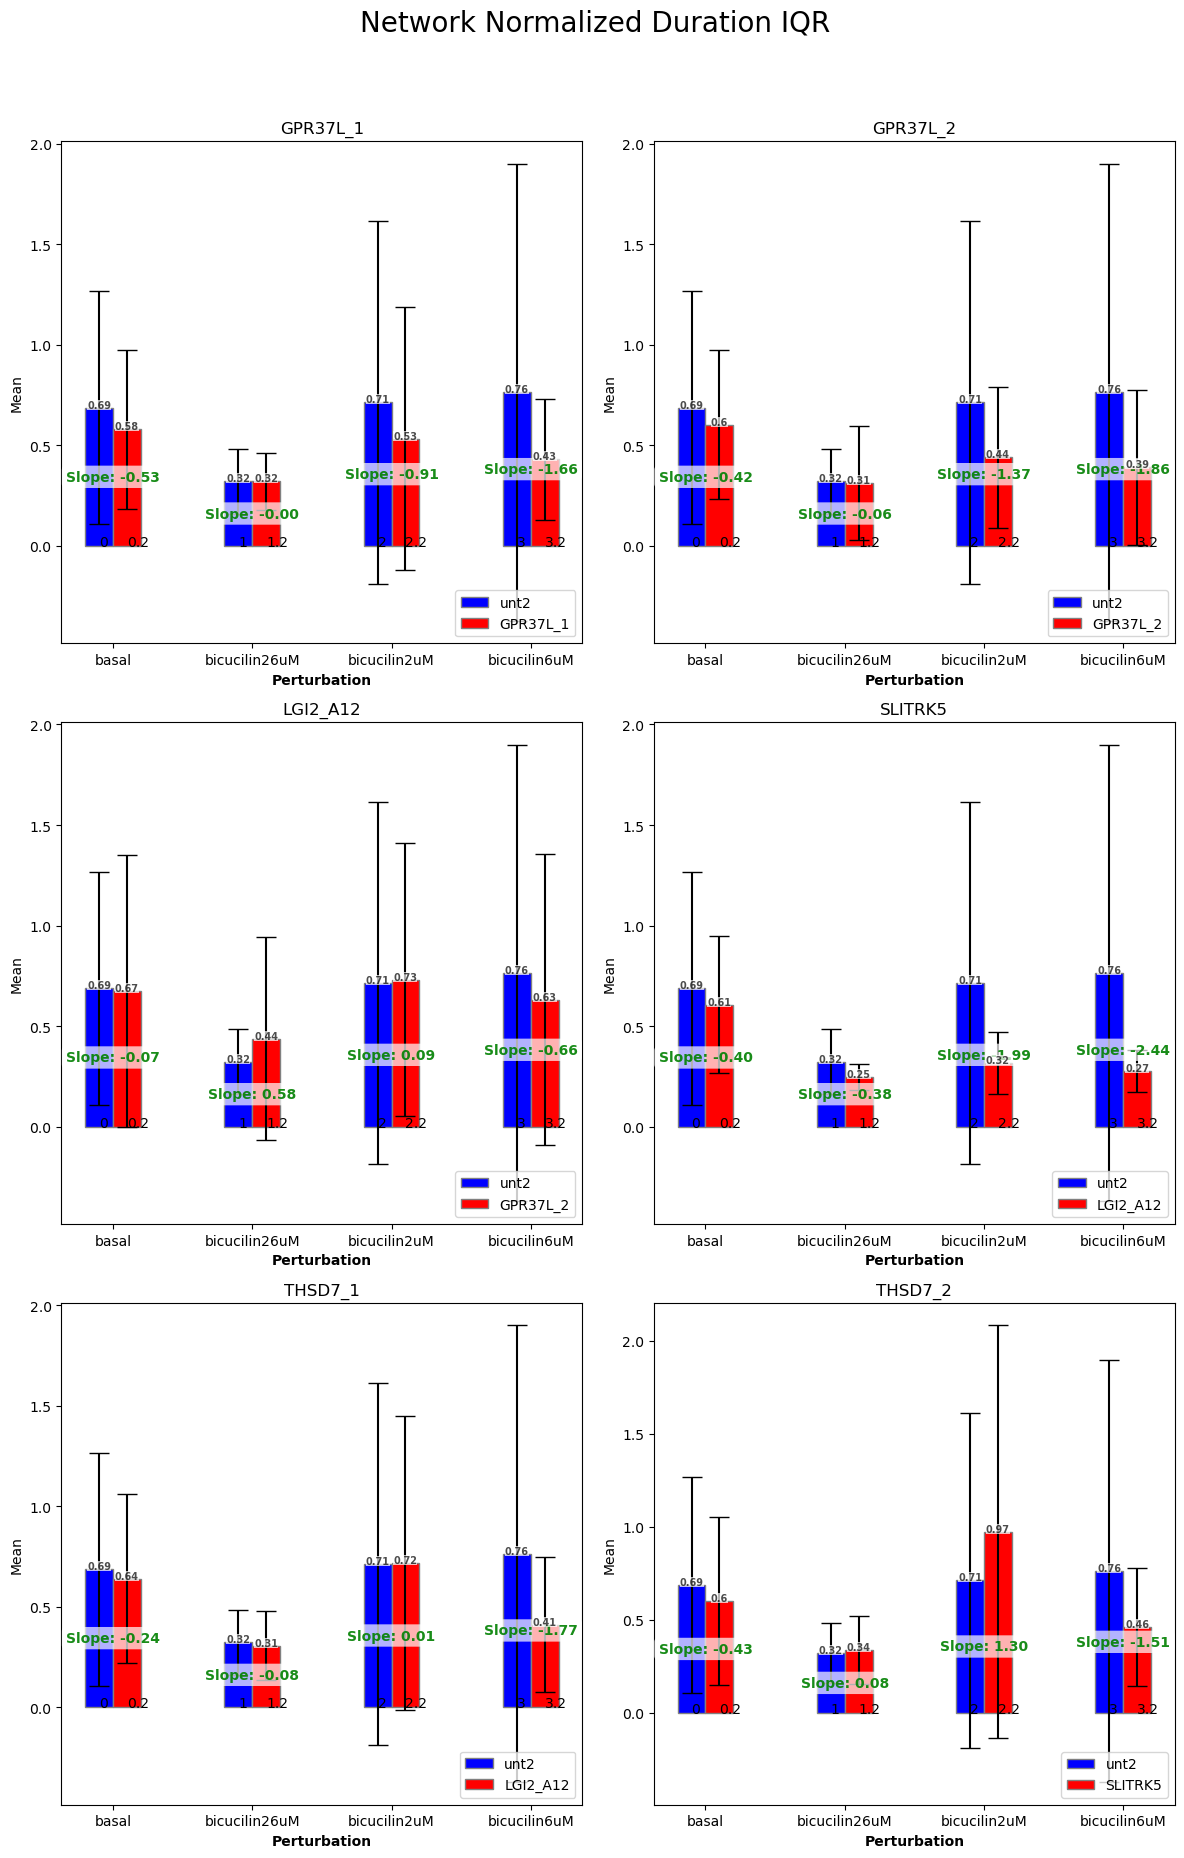

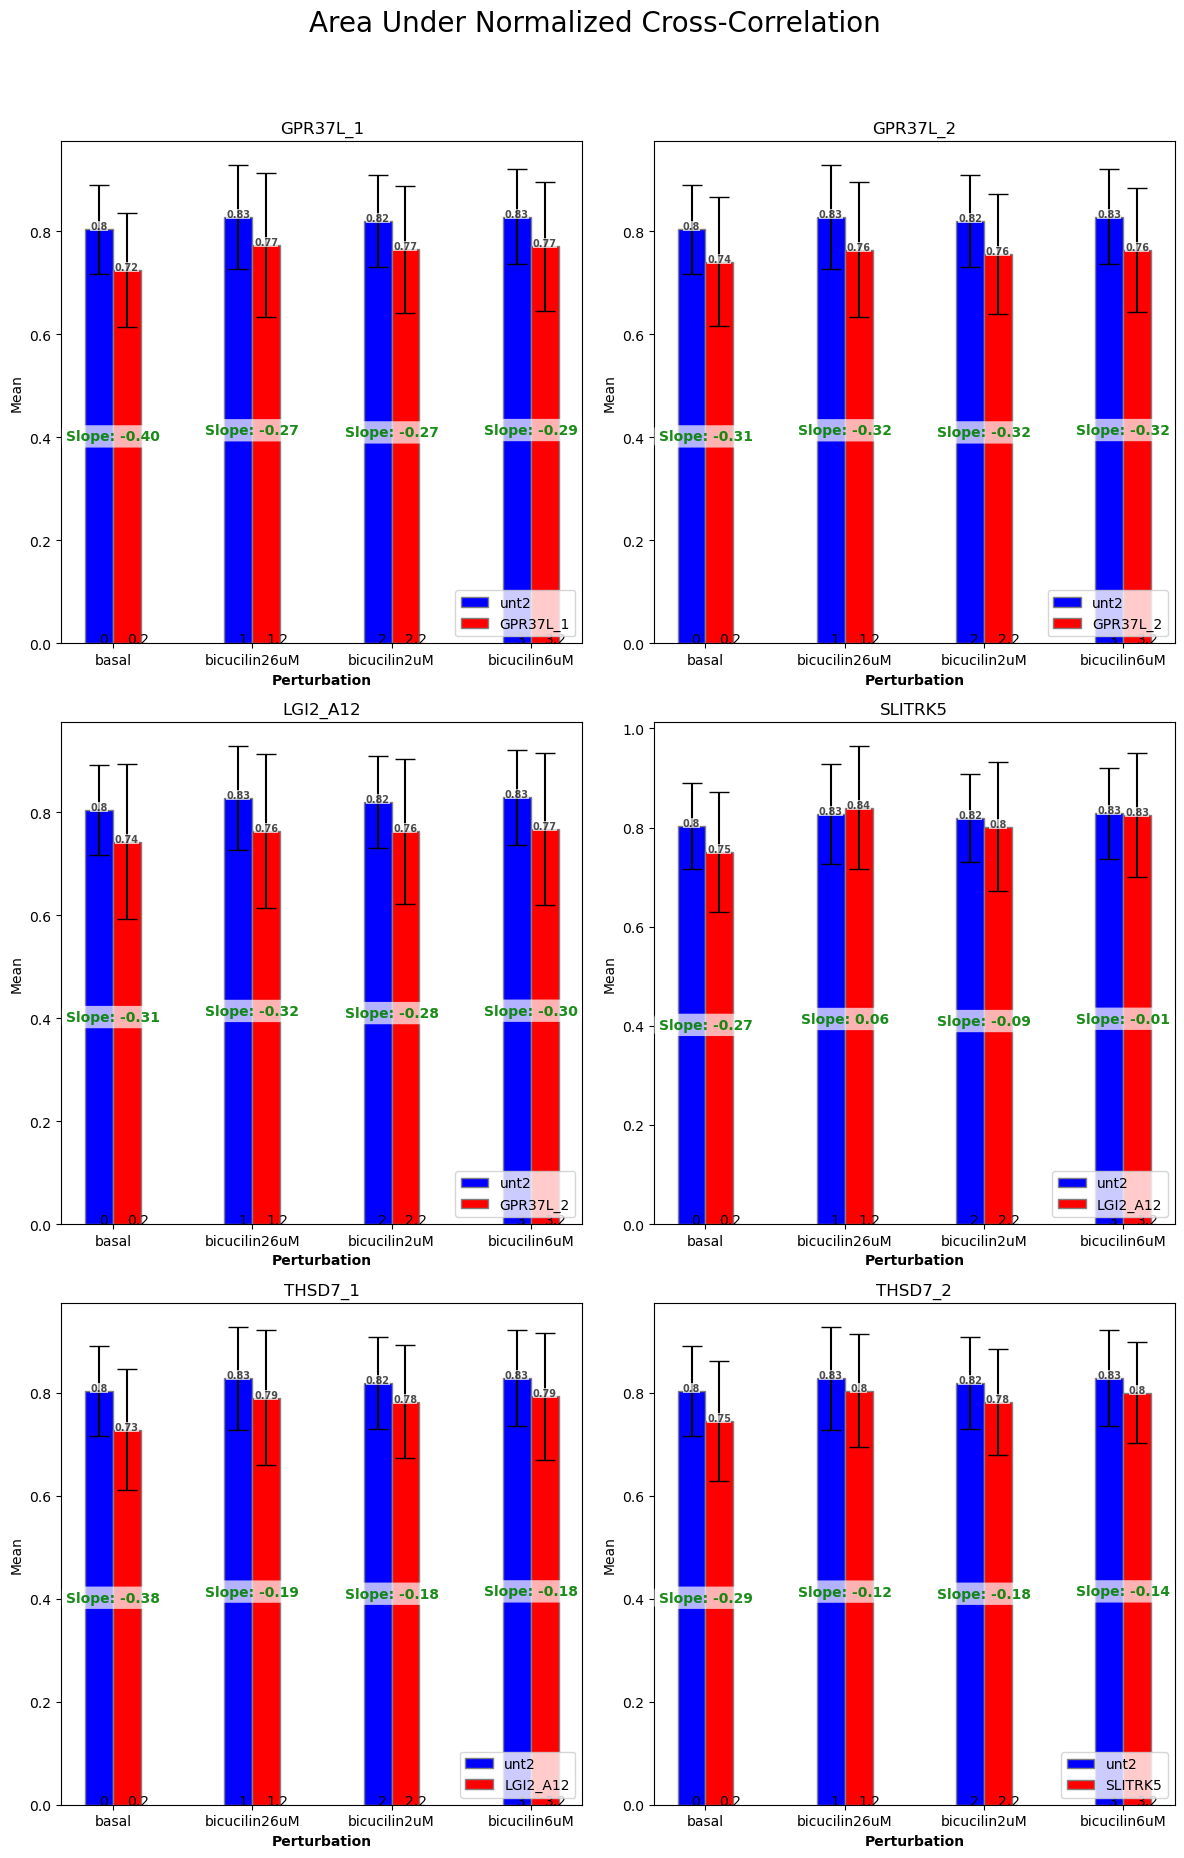

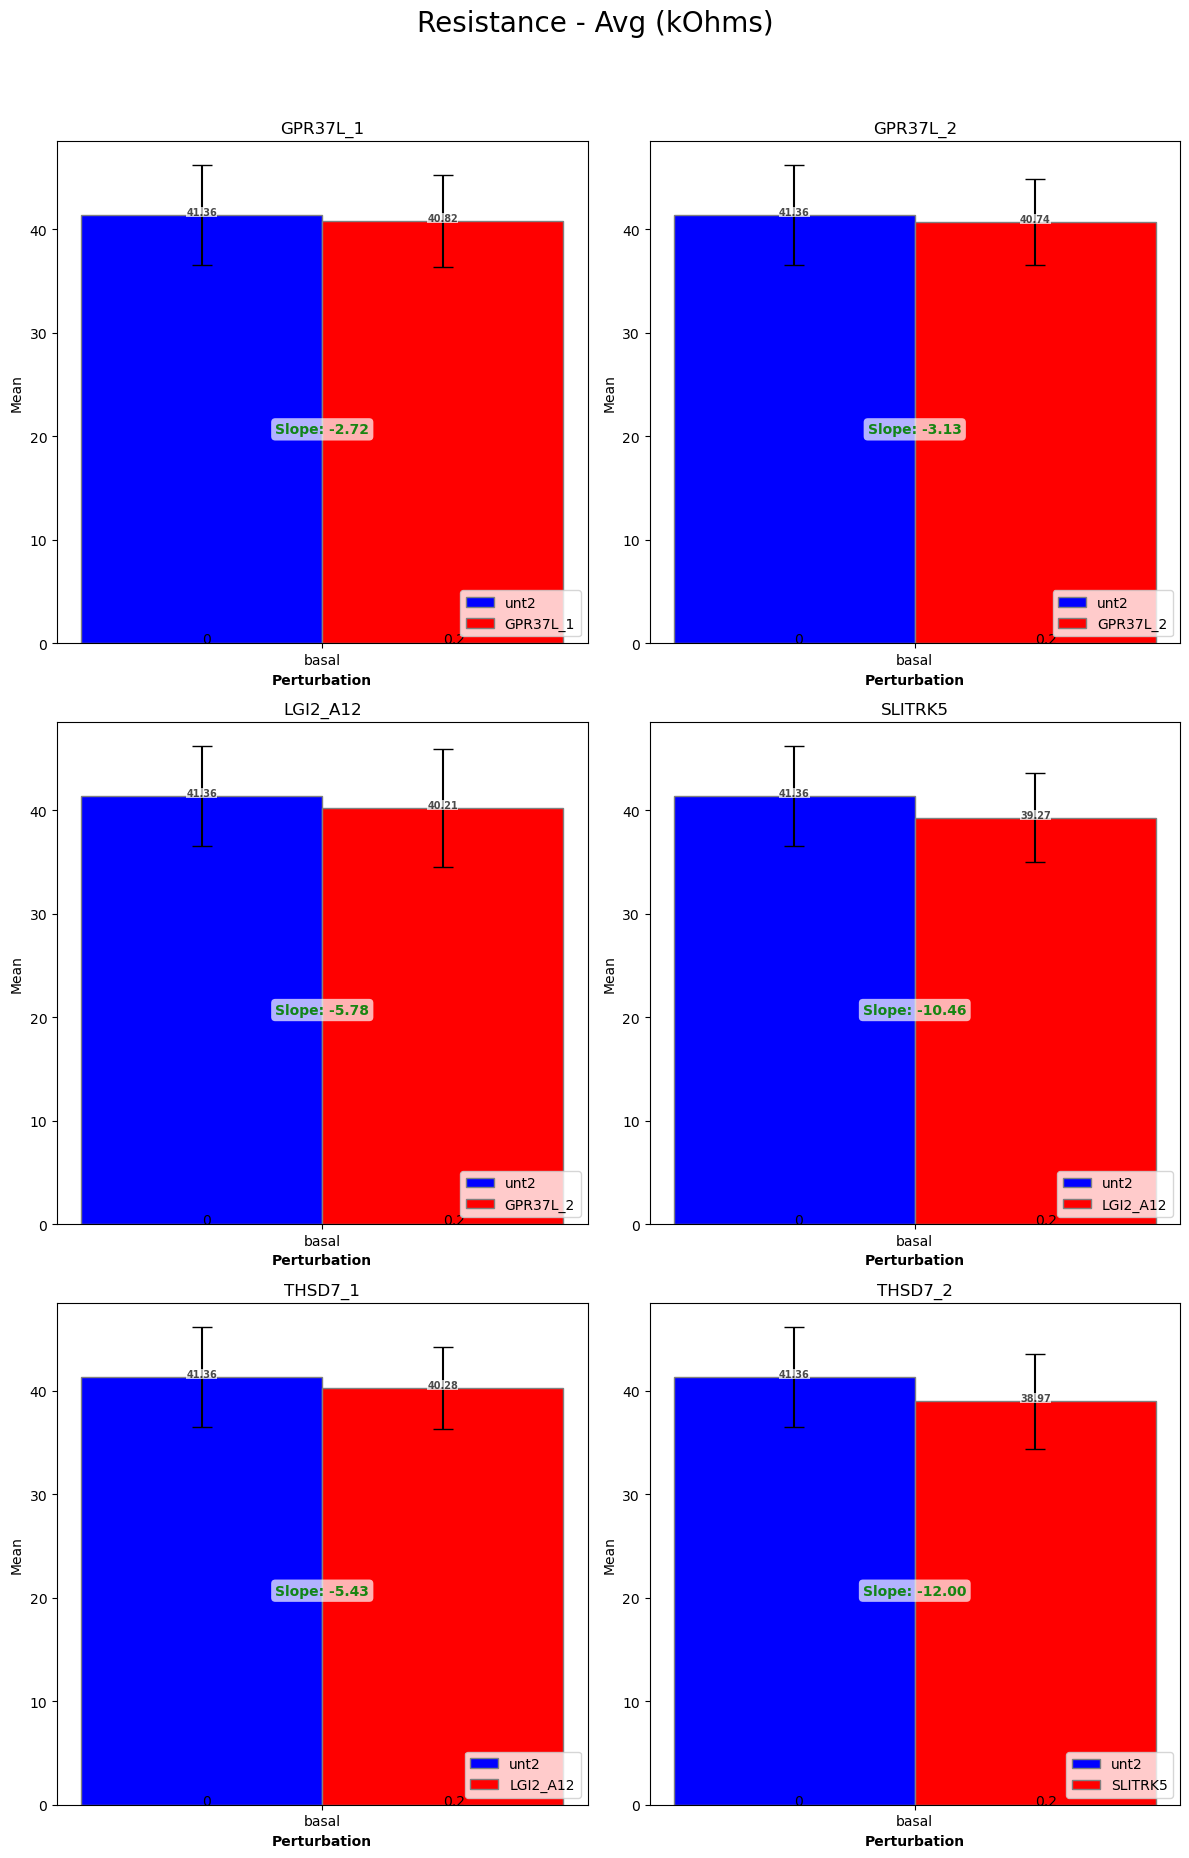

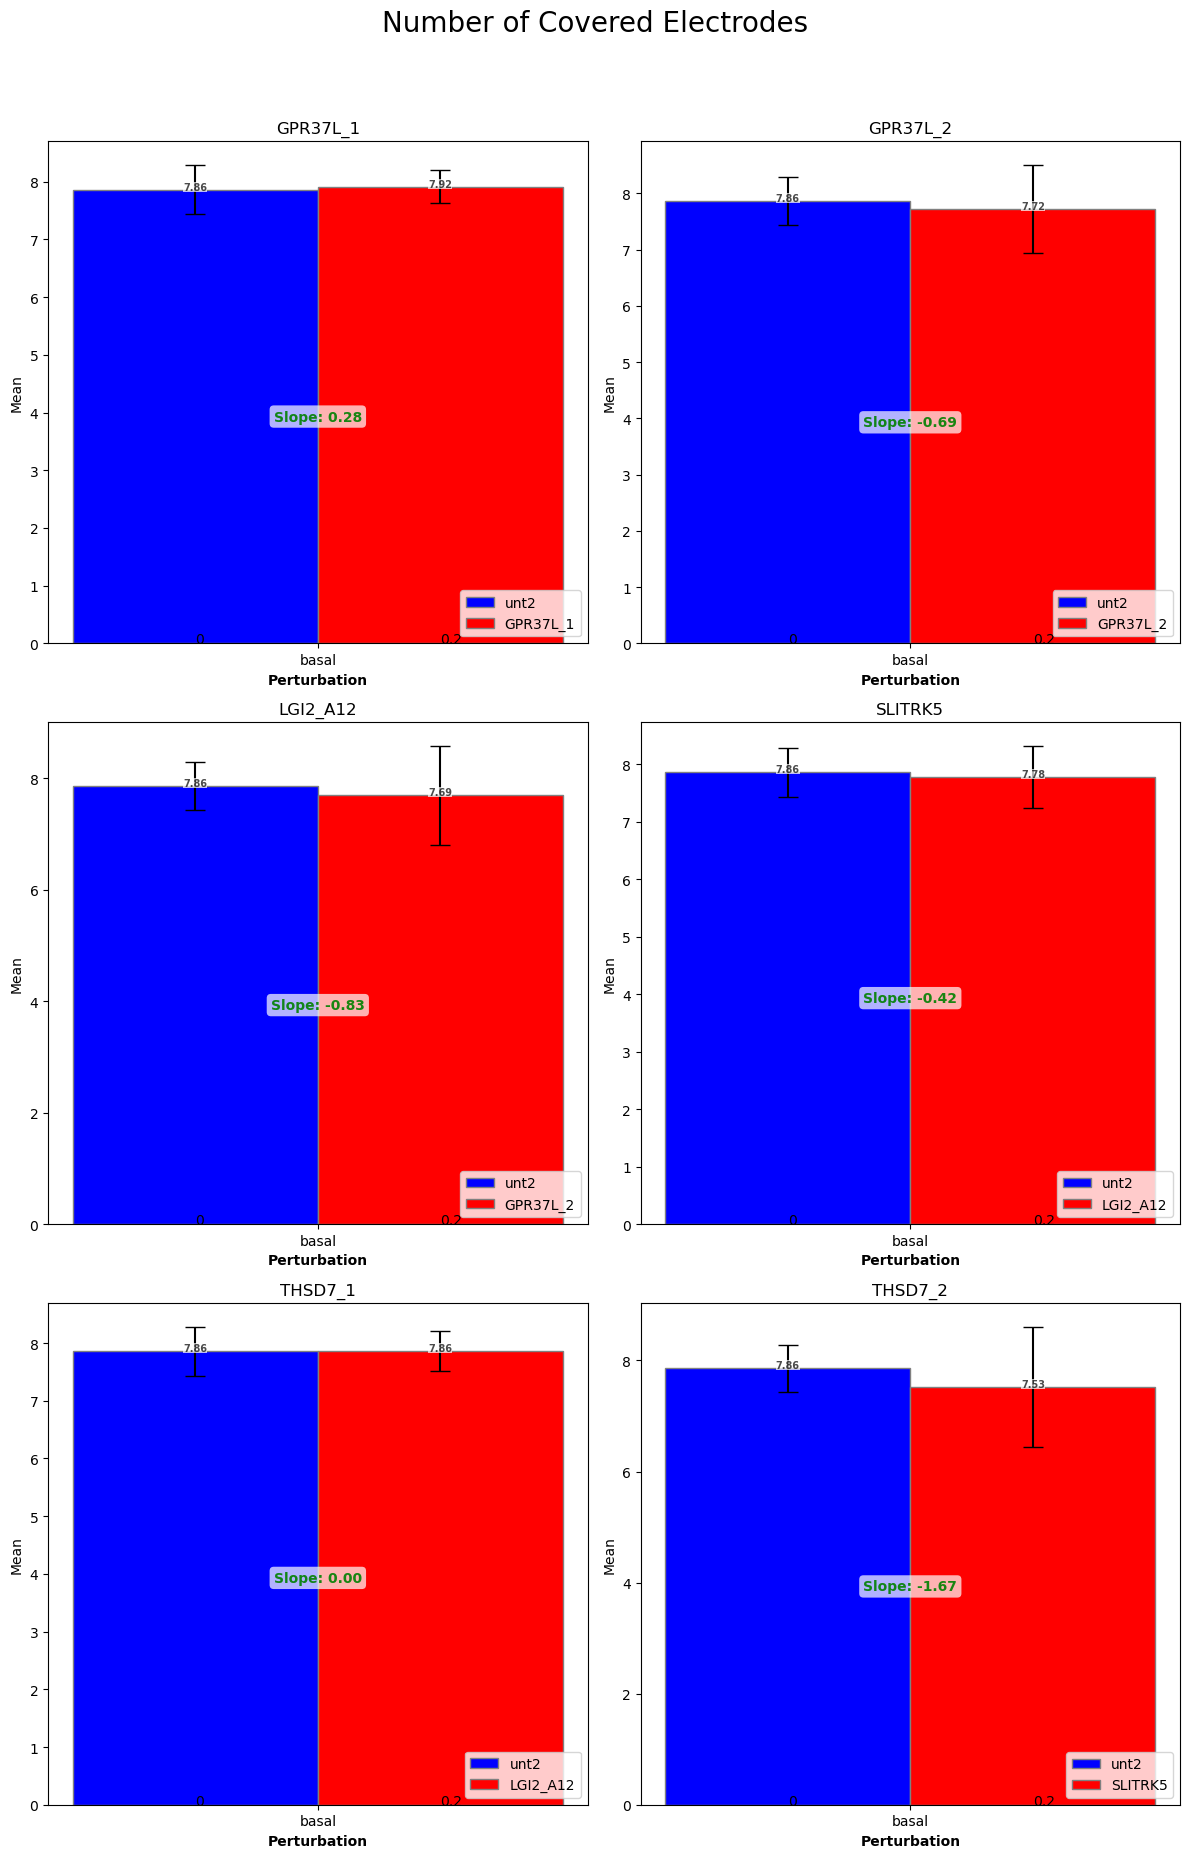

In [276]:
for test_param, table in TestParams_dict.items():
    calculate_ANOVA(test_param, table, control_var="unt2")